# Spatial statistics on hsdm hiprfish images

## Setup

Imports

In [394]:
import os
import re
import gc
import sys
import glob
import yaml
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
from time import time, sleep
import aicspylibczi as aplc
import matplotlib.pyplot as plt
from collections import defaultdict
# from scipy.cluster import hierarchy
from sklearn.neighbors import NearestNeighbors
import sklearn.cluster as clst
import hdbscan
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# from skimage.feature import peak_local_max
# from matplotlib_scalebar.scalebar import ScaleBar
# from sklearn.cluster import AgglomerativeClustering
# from scipy.spatial.distance import squareform, pdist
# from skimage.segmentation import watershed, relabel_sequential
# from skimage.measure import label, regionprops_table, regionprops

import cv2
import libpysal as ps
from esda.moran import Moran, Moran_BV
from libpysal.weights import W
import pointpats.quadrat_statistics as qs
from pointpats import PointPattern, RectangleM
from pointpats import distance_statistics as dst
from pointpats import PoissonPointProcess as csr
from pointpats.window import Window, poly_from_bbox, as_window, to_ccf

Get workdir

In [ ]:
cluster = ""
workdir = "/workdir/bmg224/harvard_dental/manuscript/code"
os.chdir(cluster + workdir)


In [572]:
os.getcwd()

'/local/workdir/bmg224/harvard_dental/manuscript/code'

In [ ]:
%load_ext autoreload
%autoreload 2
functions_path = '/workdir/bmg224/manuscripts/mgefish/code/functions'

sys.path.append(cluster + functions_path)

import fn_general_use as fgu
import image_plots as ip
# import segmentation_func as sf
import fn_hiprfish_classifier as fhc
import fn_spectral_images as fsi
import fn_analysis_plots as apl

Get czi filenames

In [ ]:
input_table_fn = "input_table_all.csv"
input_table = pd.read_csv(input_table_fn)
filenames = input_table["filenames"]

In [ ]:
dict_date_sn_fns = defaultdict(lambda: defaultdict(list))
for fn in filenames:
    bn = os.path.split(fn)[1]
    date, bn = re.split("(?<=^\d{4}_\d{2}_\d{2})_", bn)
    sn, ext = re.split("(?<=fov_\d{2})", bn)
    dict_date_sn_fns[date][sn].append(fn)

Get processed filename formats

In [ ]:
out_dir = "../outputs/segmentation_2024_03_07/{date}/{date}_{sn}"
out_fmt_classif = out_dir + "/classif"
centroid_sciname_fmt = out_fmt_classif + "/{date}_{sn}_centroid_sciname.csv"

Get color dict

In [380]:
sciname_list = [
    "Corynebacterium",
    "Actinomyces",
    "Rothia",
    "Capnocytophaga",
    "Prevotella",
    "Porphyromonas",
    "Streptococcus",
    "Gemella",
    "Veillonella",
    "Selenomonas",
    "Lautropia",
    "Neisseriaceae",
    "Pasteurellaceae",
    "Campylobacter",
    "Fusobacterium",
    "Leptotrichia",
    "Treponema",
    "TM7",
]
colors = plt.get_cmap("tab20").colors
# colors = [c + (1,) for c in colors]
dict_sciname_color = dict(zip(sciname_list, colors))
dict_sciname_color["Neisseria"] = dict_sciname_color["Neisseriaceae"]
dict_sciname_color["Saccharibacteria"] = dict_sciname_color["TM7"]
dict_sciname_color["TM"] = dict_sciname_color["TM7"]

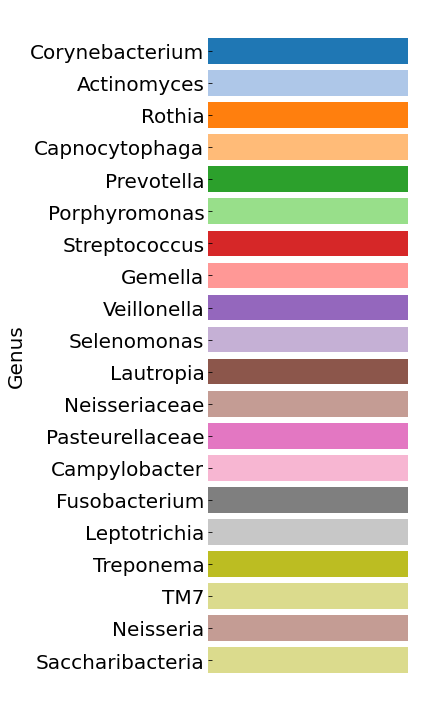

In [302]:
ip.taxon_legend(list(dict_sciname_color.keys()), list(dict_sciname_color.values()))
out_fn = "../outputs/segmentation_2024_03_07/taxon_legend.png"
ip.save_fig(out_fn)

Pick an image to test

In [541]:
date = "2023_02_08"
sn = "hsdm_group_1_sample_12_fov_01"
czi_fns = dict_date_sn_fns[date][sn]
czi_fns

[]

Get coordinates and labels

In [ ]:
centroid_sciname_fn = centroid_sciname_fmt.format(date=date, sn=sn)
centroid_sciname = pd.read_csv(centroid_sciname_fn)
coords = np.array([eval(c) for c in centroid_sciname["coord"].values])
scinames = centroid_sciname["sciname"].values
scn_unq = np.unique(scinames)

## Global Spatial autocorrelation

Get adjacency  

In [ ]:
radius_um = 3

res_mpix = fsi.get_resolution(czi_fns[0])
res_umpix = res_mpix * 1e6
radius_pix = radius_um / res_umpix
neigh = NearestNeighbors(radius=radius_pix)
nbrs = neigh.fit(coords)
nn_dists, nn_inds = nbrs.radius_neighbors(coords)

In [ ]:
print('Pixel radius', radius_pix)
_ = plt.hist([len(ni) for ni in nn_inds])
_ = plt.xlabel('Number of cells within ' + str(radius_um) + 'μm')

Build weights matrix

In [ ]:
nn_inds[0]

In [ ]:
neighbors = {}
for i, (nn_i) in enumerate(nn_inds):
    neighbors[i] = [ni for ni in nn_i if ni != i]
neighbors[0]

In [ ]:
w = W(neighbors)

Get join counts stat for each taxon

In [ ]:
lw = 1
ft = 7
dims = (2, 1)
l_col = 'k'
colors = apl.get_cmap_listed("tab10")
line_colors = [colors[0], colors[1]]
xlabel = ""
xticks = (1, 1.7)
xlims = (0.65, 2.05)
ylabel = ""
yticks = []
pad = 0.2
h = 100
dpi=500

spot_size = 3
dims_im = (4,4)

xlim = (0, np.max(coords[:, 1]))
ylim = (0, np.max(coords[:, 0]))

moran_dir = out_dir + '/spatial_stats/morans_i'
moran_plot_fmt = moran_dir + "/{date}_{sn}_sciname_{scn}_moran_plot.png"
scatter_plot_fmt = moran_dir + "/{date}_{sn}_sciname_{scn}_scatter_plot.png"
moran_table_fmt = moran_dir + "/{date}_{sn}_moran_values.csv"

moran_table = defaultdict(list)
for scn in scn_unq:
    # calculate morans i
    col = dict_sciname_color[scn]
    bool_scn = scinames == scn
    y = bool_scn * 1
    mi = Moran(y, w)
    print(scn, mi.I, mi.p_sim)
    moran_table["sciname"].append(scn)
    moran_table["I_expected"].append(mi.EI)
    moran_table["I_measured"].append(mi.I)
    moran_table["p_simulation"].append(mi.p_sim)
    # PLot the simluation vs observed
    fig, ax = apl.general_plot(col=l_col, dims=dims, lw=lw, ft=ft, pad=pad)
    apl.plot_morans_i_sim_obj(ax, mi, lw=lw, ft=ft, col=col, l_col=l_col)
    moran_fn = moran_plot_fmt.format(date=date, sn=sn, scn=scn)
    ip.check_dir(moran_fn)
    ip.save_fig(moran_fn)
    plt.show()
    plt.close()
    # Plot the scatter locations
    coord_scn = coords[bool_scn]
    fig, ax = ip.general_plot(col='w', dims=dims_im, lw=lw, ft=ft)
    ax.scatter(coord_scn[:,1], coord_scn[:,0], s=spot_size, color=col)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    ax.invert_yaxis()
    ax.set_aspect('equal')
    scatter_fn = scatter_plot_fmt.format(date=date, sn=sn, scn=scn)
    ip.check_dir(scatter_fn)
    ip.save_fig(scatter_fn, dpi=dpi)
    plt.show()
    plt.close()

moran_table_fn = moran_table_fmt.format(date=date, sn=sn)
ip.check_dir(moran_table_fn)
pd.DataFrame(moran_table).to_csv(moran_table_fn, index=False)

## Bivariate global correlation

In [ ]:
lw = 1
ft = 7
dims = (2, 1)
l_col = 'k'
colors = apl.get_cmap_listed("tab10")
line_colors = [colors[0], colors[1]]
xlabel = ""
xticks = (1, 1.7)
xlims = (0.65, 2.05)
ylabel = ""
yticks = []
pad = 0.2
h = 100
dpi=500

spot_size = 1
dims_im = (4,4)

xlim = (0, np.max(coords[:, 1]))
ylim = (0, np.max(coords[:, 0]))

moran_bv_dir = out_dir + '/spatial_stats/moran_bv'
moran_bv_plot_fmt = moran_bv_dir + "/{date}_{sn}_sciname_{scn}_moran_plot.png"
scatter_plot_fmt = moran_bv_dir + "/{date}_{sn}_scinames_{scn0}_{scn1}_scatter_plot.png"
moran_table_fmt = moran_bv_dir + "/{date}_{sn}_moran_bv_values.csv"

moran_bv_table = defaultdict(list)
for i, scn0 in enumerate(scn_unq):
    for j, scn1 in enumerate(scn_unq):
        if i < j:
            # calculate morans i
            col0 = dict_sciname_color[scn0]
            col1 = dict_sciname_color[scn1]
            bool_scn0 = scinames == scn0
            bool_scn1 = scinames == scn1
            y0 = bool_scn0 * 1
            y1 = bool_scn1 * 1
            mbv = Moran_BV(y0, y1, w)
            print(scn0, scn1, mbv.EI_sim, mbv.I, mbv.p_sim)
            moran_bv_table["sciname0"].append(scn0)
            moran_bv_table["sciname1"].append(scn0)
            moran_bv_table["I_expected"].append(mbv.EI_sim)
            moran_bv_table["I_measured"].append(mbv.I)
            moran_bv_table["p_simulation"].append(mbv.p_sim)
            # PLot the simluation vs observed
            fig, ax = apl.general_plot(col=l_col, dims=dims, lw=lw, ft=ft, pad=pad)
            apl.plot_morans_i_sim_obj(ax, mbv, lw=lw, ft=ft, col=col0, l_col=l_col)
            # moran_fn = moran_plot_fmt.format(date=date, sn=sn, , scn0=scn1, scn0=scn1)
            # ip.check_dir(moran_fn)
            # ip.save_fig(moran_fn)
            plt.show()
            plt.close()
            # Plot the scatter locations
            coord_scn0 = coords[bool_scn0]
            coord_scn1 = coords[bool_scn1]
            fig, ax = ip.general_plot(col='w', dims=dims_im, lw=lw, ft=ft)
            ax.scatter(coord_scn0[:,1], coord_scn0[:,0], s=spot_size, color=col0)
            ax.scatter(coord_scn1[:,1], coord_scn1[:,0], s=spot_size, color=col1)
            ax.set_xlim(xlim[0], xlim[1])
            ax.set_ylim(ylim[0], ylim[1])
            ax.invert_yaxis()
            ax.set_aspect('equal')
            # scatter_fn = scatter_plot_fmt.format(date=date, sn=sn, scn0=scn1, scn0=scn1)
            # ip.check_dir(scatter_fn)
            # ip.save_fig(scatter_fn, dpi=dpi)
            plt.show()
            plt.close()

# moran_bv_table_fn = moran_bv_table_fmt.format(date=date, sn=sn)
# ip.check_dir(moran_bv_table_fn)
# pd.DataFrame(moran_bv_table).to_csv(moran_bv_table_fn, index=False)

## Pair correlation

In [ ]:
dmax = 205
stepsize=5

dims=(10,5)
ft=12
lw=2

def deriv(K, h):
    return np.diff(K) / np.diff(h)


# Define distance range
res_mpix = fsi.get_resolution(czi_fns[0])
res_umpix = res_mpix * 1e6
d = np.arange(0, dmax, stepsize)
dpix = d / res_umpix
# Get cells window
convex_hull = ps.cg.convex_hull(coords.tolist())
ch_arr = np.array(to_ccf(convex_hull))
plt.plot(ch_arr[:,1], ch_arr[:,0])
plt.gca().invert_yaxis()
window = Window([convex_hull])

for scn in scn_unq[3:5]:
    print(scn)
    # Get point pattern
    col_obs = dict_sciname_color[scn]
    bool_scn = scinames == scn
    coord_scn = coords[bool_scn]
    pp = PointPattern(coord_scn, window=window)
    # Measure L values
    lenv = dst.L(pp, d=dpix)
    # Plot L values
    fig, ax = ip.general_plot(dims=dims, ft=ft, col='k', lw=lw)
    x = lenv.d
    ax.plot(x, lenv.l, lw=lw, color=col_obs)
    xlab = np.arange(0, dmax, 10)
    xticks = xlab / res_umpix
    _ = ax.set_xticks(xticks, labels=xlab)
    ax.plot([xticks[0], xticks[-1]],[0,0], 'k')
    ax.set_xlim([xticks[0], xticks[-1]])
    # PLot derivative of L
    h = lenv.d
    Lpobs = deriv(lenv.l, h)
    fig, ax = ip.general_plot(dims=dims, ft=ft, col='k', lw=lw)
    x = h[:-1]
    ax.plot(x, Lpobs, lw=lw, color=col_obs)
    xlab = np.arange(0, dmax, 10)
    xticks = xlab / res_umpix
    _ = ax.set_xticks(xticks, labels=xlab)
    ax.plot([xticks[0], xticks[-1]],[0,0], 'k')
    ax.set_xlim([xticks[0], xticks[-1]])
    # PLot second derivative of L
    h = x
    Lppobs = deriv(Lpobs, h)
    fig, ax = ip.general_plot(dims=dims, ft=ft, col='k', lw=lw)
    x = h[:-1]
    ax.plot(x, Lppobs, lw=lw, color=col_obs)
    xlab = np.arange(0, dmax, 10)
    xticks = xlab / res_umpix
    _ = ax.set_xticks(xticks, labels=xlab)
    ax.plot([xticks[0], xticks[-1]],[0,0], 'k')
    ax.set_xlim([xticks[0], xticks[-1]])


Set up simulation envelope

In [ ]:

# bbox=[0,0,crf_shp[0],crf_shp[1]]
# poly = poly_from_bbox(bbox)
# window = as_window(poly)

convex_hull = ps.cg.convex_hull(coords.tolist())

In [ ]:
ch_arr = np.array(to_ccf(convex_hull))
plt.plot(ch_arr[:,1], ch_arr[:,0])
plt.gca().invert_yaxis()

In [ ]:
window = Window([convex_hull])
window.bbox

Set up point pattern

In [ ]:
scn = 'Gemella'
scn

In [ ]:
bool_scn = scinames == scn
coord_scn = coords[bool_scn]
pp = PointPattern(coord_scn, window=window)
# mge_pp = PointPattern(mge_coords_adj_order, window=window)
pp.summary()

In [ ]:
dmax = 205
stepsize=5

res_mpix = fsi.get_resolution(czi_fns[0])
res_umpix = res_mpix * 1e6
d = np.arange(0, dmax, stepsize)
dpix = d / res_umpix
d

L function

In [ ]:
lenv = dst.L(pp, d=dpix)
lenv.plot()

In [ ]:
ls_sim = '-.'
env_col = 'k'
xt_max = 100
dims=(10,5)
ft=12
lw=2
col_obs = dict_sciname_color[scn]


fig, ax = ip.general_plot(dims=dims, ft=ft, col='k', lw=lw)
x = lenv.d
ax.plot(x, lenv.l, lw=lw, color=col_obs)
# ax.plot(x, Lpmean, lw=lw, color='k', ls=ls_sim)
# ax.plot(x, Lplow, lw=lw, color=(0.5,0.5,0.5), ls=ls_sim)
# ax.plot(x, Lphigh, lw=lw, color=(0.5,0.5,0.5), ls=ls_sim)

xlim = ax.get_xlim()
# xt_max = int(xlim[1] * mge_umpix)
xlab = np.arange(0, dmax, 10)
xticks = xlab / res_umpix
_ = ax.set_xticks(xticks, labels=xlab)

ax.plot(xlim,[0,0], 'k')
# ax.set_ylim(0,10)

L derivative

In [ ]:
def deriv(K, h):
    return np.diff(K) / np.diff(h)


In [ ]:
h = lenv.d
Lpobs = deriv(lenv.l, h)
# Lpmean = pcf(lenv.mean, h)
# Lplow = pcf(lenv.low, h)
# Lphigh = pcf(lenv.high, h)


ls_sim = '-.'
env_col = 'k'
xt_max = 100
dims=(10,5)
ft=12
lw=2
col_obs = dict_sciname_color[scn]


fig, ax = ip.general_plot(dims=dims, ft=ft, col='k', lw=lw)
x = h[:-1]
ax.plot(x, Lpobs, lw=lw, color=col_obs)
# ax.plot(x, Lpmean, lw=lw, color='k', ls=ls_sim)
# ax.plot(x, Lplow, lw=lw, color=(0.5,0.5,0.5), ls=ls_sim)
# ax.plot(x, Lphigh, lw=lw, color=(0.5,0.5,0.5), ls=ls_sim)

xlim = ax.get_xlim()
# xt_max = int(xlim[1] * mge_umpix)
xlab = np.arange(0, dmax, 10)
xticks = xlab / res_umpix
_ = ax.set_xticks(xticks, labels=xlab)

ax.plot(xlim,[0,0], 'k')
# ax.set_ylim(0,10)

L second derivative

In [ ]:
h = lenv.d[:-1]
Lppobs = deriv(Lpobs, h)
# Lpmean = pcf(lenv.mean, h)
# Lplow = pcf(lenv.low, h)
# Lphigh = pcf(lenv.high, h)


ls_sim = '-.'
env_col = 'k'
xt_max = 100
dims=(10,5)
ft=12
lw=2

fig, ax = ip.general_plot(dims=dims, ft=ft, col='k', lw=lw)
x = h[:-1]
ax.plot(x, Lppobs, lw=lw, color=col_obs)
# ax.plot(x, Lpmean, lw=lw, color='k', ls=ls_sim)
# ax.plot(x, Lplow, lw=lw, color=(0.5,0.5,0.5), ls=ls_sim)
# ax.plot(x, Lphigh, lw=lw, color=(0.5,0.5,0.5), ls=ls_sim)

xlim = ax.get_xlim()
# xt_max = int(xlim[1] * mge_umpix)
xlab = np.arange(0, dmax, 10)
xticks = xlab / res_umpix
_ = ax.set_xticks(xticks, labels=xlab)
ax.plot(xlim,[0,0], 'k')

In [ ]:
# realizations = csr(pp.window, pp.n, 100, asPP=True) # simulate CSR 
# reals = realizations.realizations

In [ ]:
nn_dists = pp.nnd.squeeze()
nn_dists_um = nn_dists * res_umpix
n_ints_1um = int(np.max(nn_dists_um))

n_ints_1um

In [ ]:
Kenv = dst.K(pp, d=dpix)
Kenv.plot()

In [ ]:
ls_sim = '-.'
env_col = 'k'
xt_max = 100
dims=(10,5)
ft=12
lw=2
col_obs = dict_sciname_color[scn]


fig, ax = ip.general_plot(dims=dims, ft=ft, col='k', lw=lw)
x = d
ax.plot(x, Kenv.k, lw=lw, color=col_obs)
# ax.plot(x, Lpmean, lw=lw, color='k', ls=ls_sim)
# ax.plot(x, Lplow, lw=lw, color=(0.5,0.5,0.5), ls=ls_sim)
# ax.plot(x, Lphigh, lw=lw, color=(0.5,0.5,0.5), ls=ls_sim)

lndist = np.log(d[1:])
lnk = np.log(Kenv.k[1:])
model = LinearRegression().fit(lndist[:, None], lnk)
slope, intercept, r_value, p_value, std_err = stats.linregress(lndist, lnk)
print('slope: ', model.coef_, 'intercept: ', model.intercept_)
print(stats.pearsonr(lndist, lnk))
print(stats.linregress(lndist, lnk))

y = x**(model.coef_[0]) * math.exp(model.intercept_)
ax.plot(x, y, 'k')

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('log10(distance (μm))')
ax.set_ylabel("log10(Ripley's K)")





In [ ]:
y

In [ ]:
def pcf(K, h):
    dKdh = np.diff(K) / np.diff(h)
    return dKdh / (2 * h[1:] * np.pi)

In [ ]:
col_obs = dict_sciname_color[scn]

Robs = pcf(Kenv.k, Kenv.d)
# Rmean = pcf(Kenv.mean, Kenv.d)
# Rlow = pcf(Kenv.low, Kenv.d)
# Rhigh = pcf(Kenv.high, Kenv.d)


ls_sim = '-.'
env_col = 'k'
xt_max = 100
dims=(10,5)
ft=12
lw=2

fig, ax = ip.general_plot(dims=dims, ft=ft, col='k', lw=lw)
x = Kenv.d[:-1]
ax.plot(x, Robs, lw=lw, color=col_obs)
# ax.plot(x, Rmean, lw=lw, color='k', ls=ls_sim)
# ax.plot(x, Rlow, lw=lw, color=(0.5,0.5,0.5), ls=ls_sim)
# ax.plot(x, Rhigh, lw=lw, color=(0.5,0.5,0.5), ls=ls_sim)

xlim = ax.get_xlim()
# xt_max = int(xlim[1] * mge_umpix)
xlab = np.arange(0, xt_max, 5)
xticks = xlab / res_umpix
_ = ax.set_xticks(xticks, labels=xlab)

# ax.set_ylim(0,10)

## Lena pair correlation

In [574]:
data = pd.read_csv("/Users/lena/Desktop/test_spacestat/Ripley/2022_12_16_harvardwelch_patient_10_tooth_8_aspect_MB_depth_supra_fov_01_centroid_sciname.csv", index_col=0)
spatial_temp = data['coord']
spatial = [tuple(map(float, line.replace('[', '').replace(']', '').replace(',', '').split())) for line in spatial_temp]
x_min = np.min(np.array(spatial).T[0]); x_max = np.max(np.array(spatial).T[0])
y_min = np.min(np.array(spatial).T[1]); y_max = np.max(np.array(spatial).T[1])
area = (x_max - x_min)*(y_max - y_min)
rmax = min(x_max - x_min, y_max - y_min) / 2 # np.sqrt(area)/2
radii = np.linspace(0,rmax,50).reshape(50,1)
def ripley_K(spatial, radii):
    ## Ripley's K with edge correction
    npts = np.shape(spatial)[0]                                 # Number of events in A
    diff = np.zeros(shape = (npts*(npts-1)//2,2))               # Decomposed distances matrix
    k = 0
    for i in range(npts - 1):
        size = npts - i - 1
        diff[k:k + size] = abs(np.array(spatial[i]) - np.array(spatial[i+1:])) # distance
        k += size
    n_ripley = np.zeros(len(radii))
    distances = np.hypot(diff[:,0], diff[:,1])                      # Pythagorean Theorem (a^2+b^2=c^2)
    for r in range(len(radii)):
        n_ripley[r] = (distances<radii[r]).sum()                    # Indicator function and summation term
    n_ripley = area * 2. * n_ripley / (npts * (npts - 1))           # Expectation vector element-wise divided by scalar intensity
    return n_ripley
def ripley_K_boundary(spatial, radii=radii):
    ## Ripley's K with edge correction
    ripley = np.zeros(len(radii))
    #npts = len(spatial)
    npts = np.shape(spatial)[0]                                 # Number of events in A
    diff = np.zeros(shape = (npts*(npts-1)//2,2))               # Decomposed distances matrix
    k = 0
    for i in range(npts - 1):
        size = npts - i - 1
        diff[k:k + size] = abs(np.array(spatial[i]) - np.array(spatial[i+1:])) # distance
        k += size
    x_min = np.min(np.array(spatial).T[0]); x_max = np.max(np.array(spatial).T[0])
    y_min = np.min(np.array(spatial).T[1]); y_max = np.max(np.array(spatial).T[1])
    hor_dist = np.zeros(shape=(npts * (npts - 1)) // 2, dtype=np.double)
    ver_dist = np.zeros(shape=(npts * (npts - 1)) // 2, dtype=np.double)
    for k in range(npts - 1):                           # Finds horizontal and vertical distances from every event to nearest egde
        min_hor_dist = min(x_max - spatial[k][0], spatial[k][0] - x_min)
        min_ver_dist = min(y_max - spatial[k][1], spatial[k][1] - y_min)
        start = (k * (2 * (npts - 1) - (k - 1))) // 2
        end = ((k + 1) * (2 * (npts - 1) - k)) // 2
        hor_dist[start: end] = min_hor_dist * np.ones(npts - 1 - k)
        ver_dist[start: end] = min_ver_dist * np.ones(npts - 1 - k)
    dist = np.hypot(diff[:, 0], diff[:, 1])
    dist_ind = dist <= np.hypot(hor_dist, ver_dist)     # True if distance between events is less than or equal to distance to edge
    w1 = (1 - (np.arccos(np.minimum(ver_dist, dist) / dist) + np.arccos(np.minimum(hor_dist, dist) / dist)) / np.pi)
    w2 = (3 / 4 - 0.5 * (np.arccos(ver_dist / dist * ~dist_ind) + np.arccos(hor_dist / dist * ~dist_ind)) / np.pi)
    weight = dist_ind * w1 + ~dist_ind * w2              # Weighting term
    for r in range(len(radii)):
        ripley[r] = ((dist < radii[r]) / weight).sum()   # Indicator function with weighting term
    ripley = area * 2. * ripley / (npts * (npts - 1))
    return ripley
ripley_K =  ripley_K(spatial, radii)
ripley_K_edge =  ripley_K_boundary(spatial, radii)
ax, fig1 = plt.subplots()
fig1.plot(radii,ripley_K_edge,color='red',linewidth=2,label='K_edgeCorrect')
fig1.plot(radii,ripley_K,color='black',linewidth=2,label='K')
fig1.set_title('K Function without edge adjustment',size=20)
fig1.set_xlabel('Radii (m)',size=15); fig1.set_ylabel('K',size=15)
fig1.legend();

FileNotFoundError: [Errno 2] No such file or directory: '/Users/lena/Desktop/test_spacestat/Ripley/2022_12_16_harvardwelch_patient_10_tooth_8_aspect_MB_depth_supra_fov_01_centroid_sciname.csv'

## Cluster Size

In [ ]:
import numpy as np
import hdbscan
import libpysal as ps
from pointpats.window import Window

xlim = (0, np.max(coords[:, 1]))
ylim = (0, np.max(coords[:, 0]))

dims_im = (20,20)
spot_size = 10
lw=2
ft=20

dict_df = defaultdict(list)
for scn in scn_unq:
    # cluster coords
    col = dict_sciname_color[scn]
    bool_scn = scinames == scn
    coord_scn = coords[bool_scn]
    hdb = hdbscan.HDBSCAN(min_cluster_size=10).fit(coord_scn).labels_

    # Plot clusters
    fig, ax = ip.general_plot(col='w', dims=dims_im, lw=lw, ft=ft)
    coord_scn_cl = coord_scn[hdb != -1]
    hdb_cl = hdb[hdb != -1]
    ax.scatter(coord_scn_cl[:,1], coord_scn_cl[:,0], s=spot_size, c=hdb_cl, cmap='gist_rainbow')
    coord_scn_non = coord_scn[hdb == -1]
    ax.scatter(coord_scn_non[:,1], coord_scn_non[:,0], s=spot_size, color=[0.75]*3)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    ax.invert_yaxis()
    ax.set_aspect('equal')
    # print(np.unique(hdb))

    # count spots in clusters and plot convex hull on clusters
    # areas = []
    counts = []
    for cl in np.unique(hdb_cl):
        coords_cl = coord_scn[hdb == cl]
        ch_cl = ps.cg.convex_hull(coords_cl.tolist())
        ch_arr = np.array(to_ccf(ch_cl))
        ax.plot(ch_arr[:,1], ch_arr[:,0],'w', lw=lw)
        # w = Window([ch_cl])
        # areas.append(w.area)
        counts.append(coords_cl.shape[0])
        # cent = w.centroid
        # ax.text(cent[1], cent[0], int(w.area), color='w', fontsize=ft)
    plt.show()
    plt.close()

    # Plot power law stuff? Mori, Smith, Hsu, 2020
    counts_sort = sorted(counts)
    nclust = len(counts_sort)
    Pr = [r/nclust for r in range(nclust,0,-1)]
    fig, ax = ip.general_plot()
    lnpr = np.log(Pr) - 0.5  # improve alpha estimate Gabaix and ibragimov 2011
    lncs = np.log(counts_sort)
    ax.plot(lnpr, lncs)
    plt.show()
    plt.close()
    rval, pval = stats.pearsonr(lnpr, lncs)
    dict_df['rval'].append(rval)
    dict_df['pval'].append(pval)
    model = LinearRegression().fit(lncs[:, None], lnpr)
    dict_df['alpha'].append(1 / model.coef_[0])
    dict_df['coef'].append(model.coef_[0])
    dict_df['intercept'].append(model.intercept_)
    dict_df['score'].append(model.score(lncs[:, None], lnpr))



In [ ]:
pd.DataFrame(np.array([[0,1],[2,3]]), columns=['a','b'], index=['1','2'])

# Look at feature matrix

In [203]:
sample_compare_dir =  '../outputs/segmentation_2024_03_07/compare_samples'
feature_matrix_fn = sample_compare_dir + '/samples_feature_matrix.csv'

In [182]:
feature_matrix = pd.read_csv(feature_matrix_fn, index_col=0)
feature_matrix = feature_matrix.fillna(0)
X = feature_matrix.values
feature_matrix.shape

(52, 360)

### UMAP

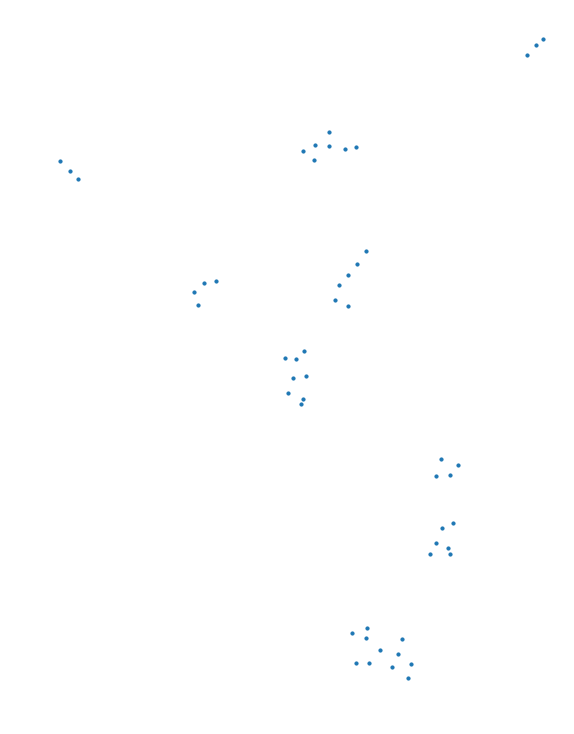

In [183]:
# n_neighbors=2, min_dist=1

fig, ax = ip.general_plot(dims=(10,10), col='w')
fit = umap.UMAP(n_neighbors=2, min_dist=1).fit(X)
u = fit.embedding_
ax.scatter(u[:,0], u[:,1], s=10)
ax.set_aspect('equal')


In [185]:
kmeans = clst.KMeans(n_clusters=9).fit(u)
cl_kmeans = kmeans.labels_

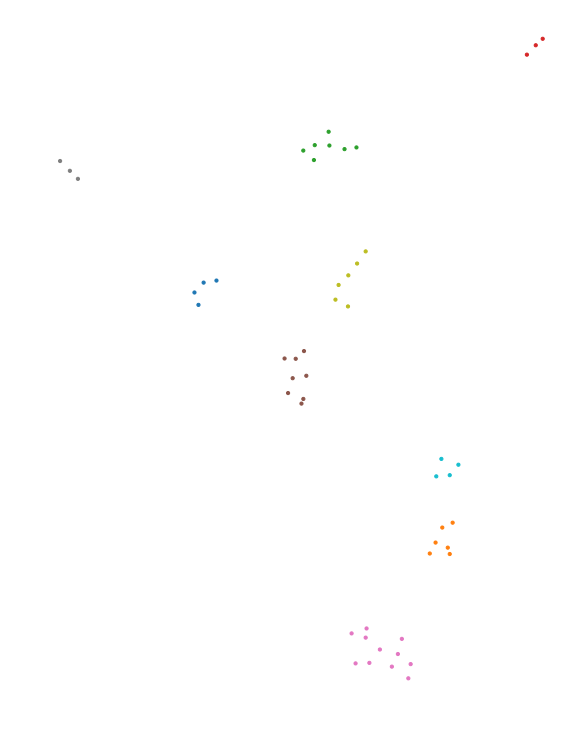

In [186]:
fig, ax = ip.general_plot(dims=(10, 10), col="w")

ax.scatter(u[:, 0], u[:, 1], s=10, c=cl_kmeans, cmap='tab10')
ax.set_aspect("equal")

In [187]:
for cl in np.unique(cl_kmeans):
    print(cl)
    bool_cl = cl_kmeans == cl
    print(feature_matrix.index.values[bool_cl])

0
['2023_02_18_hsdm_group_batch1_patient_1_fov_01'
 '2023_02_18_hsdm_group_batch1_patient_7_fov_01'
 '2022_12_16_harvardwelch_patient_9_tooth_15_aspect_MB_depth_supra_fov_01'
 '2022_12_16_harvardwelch_patient_9_tooth_15_aspect_MB_depth_supra_fov_02']
1
['2023_02_18_hsdm_group_batch1_patient_3_fov_01'
 '2023_02_18_hsdm_group_I_patient_13_fov_01'
 '2022_12_16_harvardwelch_patient_10_tooth_8_aspect_MB_depth_supra_fov_02'
 '2022_12_16_harvardwelch_patient_14_tooth_14_aspect_MB_depth_sub_fov_03'
 '2022_12_16_harvardwelch_patient_19_tooth_15_aspect_MF_depth_sub_fov_01'
 '2022_12_16_harvardwelch_patient_9_tooth_15_aspect_MB_depth_supra_fov_03']
2
['2023_10_18_hsdm_slide_IIL_fov_01' '2023_10_18_hsdm_slide_IIIB_fov_01'
 '2023_10_16_hsdm_slide_IB_fov_01' '2023_10_16_hsdm_slide_IB_fov_03'
 '2023_10_16_hsdm_slide_IL_fov_01' '2023_10_16_hsdm_slide_IL_fov_02'
 '2023_10_16_hsdm_slide_IL_fov_03']
3
['2023_02_18_hsdm_group_I_patient_11_fov_02'
 '2022_12_16_harvardwelch_patient_14_tooth_14_aspect_MB_dep

### PCA

In [188]:

pca = PCA(n_components=10).fit(X)
pca.explained_variance_ratio_

array([0.24131906, 0.21483132, 0.15020428, 0.14268255, 0.05619744,
       0.04171619, 0.02937791, 0.02079674, 0.01408374, 0.01162037])

In [189]:
cols = feature_matrix.columns.values

for i, c in enumerate(pca.components_):
    if i < 4:
        print(i)
        vlow = np.sort(c)[:3]
        vhigh = np.sort(c)[-3:]
        for v in [vlow, vhigh]:
            for v_ in v:
                bool_v = c == v_
                print(v_)
                print(cols[bool_v])



0
-0.6539640722359239
['Pasteurellaceae_power_law']
-0.6208690924662038
['Veillonella_power_law']
-0.3895968572562473
['Prevotella_power_law']
0.04557523350221581
['Campylobacter_power_law']
0.05540354455603246
['Fusobacterium_power_law']
0.07673938898093141
['Gemella_power_law']
1
-0.4901724935493404
['Pasteurellaceae_power_law']
-0.1862073052382161
['Fusobacterium_power_law']
-0.17031869093485497
['TM7_power_law']
0.30005862879963535
['Veillonella_power_law']
0.4116042651272328
['Prevotella_power_law']
0.5965174371176613
['Gemella_power_law']
2
-0.6777103639102668
['Gemella_power_law']
-0.5392212310990551
['Pasteurellaceae_power_law']
-0.1896045223281036
['Porphyromonas_power_law']
0.06471893686375851
['Gemella_frac']
0.07104074005186371
['Prevotella_power_law']
0.4260457798664911
['Veillonella_power_law']
3
-0.7658269301635021
['Prevotella_power_law']
-0.08032755970777293
['Lautropia_power_law']
-0.04222470845381509
['Rothia_power_law']
0.11584733690424531
['Leptotrichia_power_law']

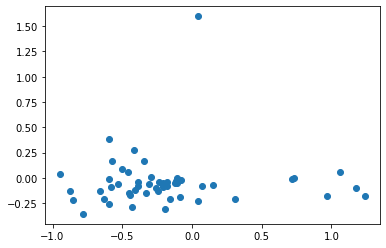

In [190]:
pca = PCA()
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
pca_fit = pca.fit(Xs)
Xt = pca_fit.transform(X)
plot = plt.scatter(Xt[:, 0], Xt[:, 1])

In [191]:
for i, c in enumerate(pca_fit.components_):
    if i < 4:
        print(i)
        vlow = np.sort(c)[:3]
        vhigh = np.sort(c)[-3:]
        for v in [vlow, vhigh]:
            for v_ in v:
                bool_v = c == v_
                print(v_)
                print(cols[bool_v])

0
-0.16462737039044864
['Neisseriaceae_power_law']
-0.1562677091073986
['Neisseriaceae_Fusobacterium_moran_bv']
-0.15617990840238513
['Fusobacterium_Neisseriaceae_moran_bv']
0.15114188011947813
['TM7_moran_i']
0.17228498548043475
['TM7_frac']
0.1802041889972738
['Neisseriaceae_moran_i']
1
-0.20630358887790906
['Lautropia_Fusobacterium_moran_bv']
-0.20580356079895387
['Leptotrichia_Fusobacterium_moran_bv']
-0.20570131031965153
['Fusobacterium_Leptotrichia_moran_bv']
0.2065463721116931
['Actinomyces_Leptotrichia_moran_bv']
0.2067222405413524
['Leptotrichia_Actinomyces_moran_bv']
0.2098056674052353
['Rothia_frac']
2
-0.1898103417374192
['Campylobacter_power_law']
-0.17053579077696396
['Streptococcus_Lautropia_moran_bv']
-0.167023020486466
['Lautropia_Streptococcus_moran_bv']
0.12003439810363647
['Porphyromonas_Streptococcus_moran_bv']
0.14840047180259086
['Streptococcus_frac']
0.1793013717645
['Campylobacter_moran_i']
3
-0.16838610675198828
['Pasteurellaceae_Neisseriaceae_moran_bv']
-0.16

In [192]:
kmeans_pca = clst.KMeans(n_clusters=3).fit(Xt[:,:2])
cl_kmeans_pca = kmeans_pca.labels_

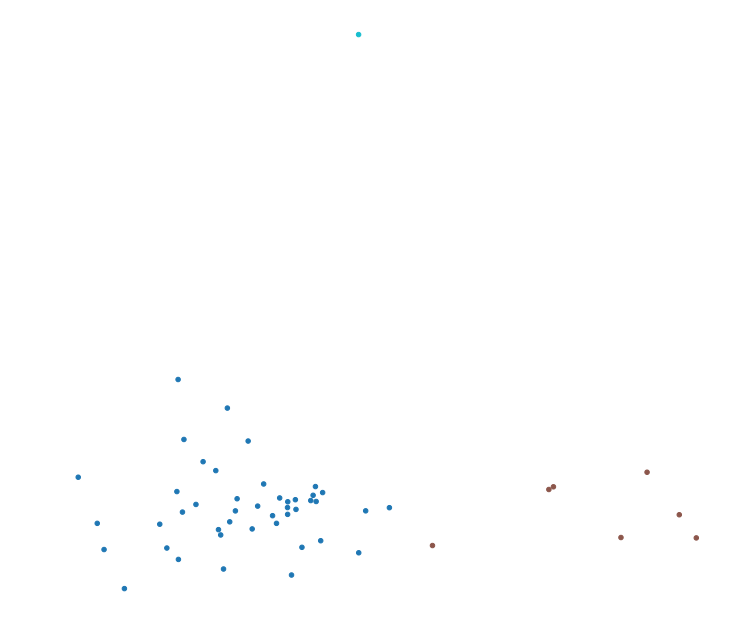

In [193]:
fig, ax = ip.general_plot(dims=(10, 10), col="w")

ax.scatter(Xt[:, 0], Xt[:, 1], s=20, c=cl_kmeans_pca, cmap="tab10")
ax.set_aspect("equal")

In [194]:
for cl in np.unique(cl_kmeans_pca):
    print(cl)
    bool_cl = cl_kmeans_pca == cl
    print(feature_matrix.index.values[bool_cl])

0
['2023_02_18_hsdm_group_batch2_patient_11_fov_01'
 '2023_02_18_hsdm_group_batch1_patient_1_fov_01'
 '2023_02_18_hsdm_group_batch1_patient_1_fov_02'
 '2023_02_18_hsdm_group_batch1_patient_2_fov_01'
 '2023_02_18_hsdm_group_batch1_patient_3_fov_01'
 '2023_02_18_hsdm_group_batch1_patient_4_fov_01'
 '2023_02_18_hsdm_group_batch1_patient_7_fov_01'
 '2023_02_18_hsdm_group_batch2_patient_10_fov_01'
 '2023_02_18_hsdm_group_batch2_patient_9_fov_01'
 '2023_02_18_hsdm_group_II_patient_6_fov_01'
 '2023_02_18_hsdm_group_II_patient_7_fov_01'
 '2023_02_18_hsdm_group_II_patient_7_fov_02'
 '2023_02_18_hsdm_group_I_patient_11_fov_02'
 '2023_02_18_hsdm_group_I_patient_13_fov_01'
 '2023_02_18_hsdm_group_I_patient_6_fov_01'
 '2023_02_18_hsdm_group_IV_patient_1_fov_01'
 '2023_02_18_hsdm_group_IV_patient_1_fov_02'
 '2023_10_16_hsdm_slide_IB_fov_01' '2023_10_16_hsdm_slide_IB_fov_03'
 '2022_12_16_harvardwelch_patient_10_tooth_8_aspect_MB_depth_supra_fov_01'
 '2022_12_16_harvardwelch_patient_10_tooth_8_aspect_

### Compare groups

In [466]:
dict_group_sn = {
    "healthy_tooth": [
        "2023_02_18_hsdm_group_batch1_patient_1_fov_01",
        "2023_02_18_hsdm_group_batch1_patient_1_fov_02",
        "2023_02_18_hsdm_group_batch2_patient_10_fov_01",
        "2023_02_18_hsdm_group_batch2_patient_9_fov_01",
        "2022_12_16_harvardwelch_patient_10_tooth_8_aspect_MB_depth_supra_fov_01",
        "2022_12_16_harvardwelch_patient_10_tooth_8_aspect_MB_depth_supra_fov_02",
        "2022_12_16_harvardwelch_patient_10_tooth_8_aspect_MB_depth_supra_fov_03",
        "2022_12_16_harvardwelch_patient_1_tooth_31_aspect_ML_depth_supra_fov_01",
        "2022_12_16_harvardwelch_patient_1_tooth_31_aspect_ML_depth_supra_fov_02",
        "2022_12_16_harvardwelch_patient_1_tooth_31_aspect_ML_depth_supra_fov_03",
        "2022_12_16_harvardwelch_patient_9_tooth_15_aspect_MB_depth_supra_fov_01",
        "2022_12_16_harvardwelch_patient_9_tooth_15_aspect_MB_depth_supra_fov_02",
        "2022_12_16_harvardwelch_patient_9_tooth_15_aspect_MB_depth_supra_fov_03",
        "2022_12_16_harvardwelch_patient_9_tooth_3_aspect_D_depth_supra_fov_01",
        "2022_12_16_harvardwelch_patient_9_tooth_3_aspect_D_depth_supra_fov_02",
        "2022_12_16_harvardwelch_patient_9_tooth_3_aspect_D_depth_supra_fov_03",
    ],
    "periodontitis_tooth": [
        "2023_02_18_hsdm_group_batch2_patient_11_fov_01",
        "2023_02_18_hsdm_group_batch1_patient_2_fov_01",
        "2023_02_18_hsdm_group_batch1_patient_3_fov_01",
        "2023_02_18_hsdm_group_batch1_patient_4_fov_01",
        "2023_02_18_hsdm_group_batch1_patient_7_fov_01",
    ],
    "healthy_implant": [
        "2023_02_18_hsdm_group_I_patient_11_fov_01",
        "2023_02_18_hsdm_group_I_patient_11_fov_02",
        "2023_02_18_hsdm_group_I_patient_13_fov_01",
        "2023_02_18_hsdm_group_I_patient_6_fov_01",
        "2023_10_16_hsdm_slide_IB_fov_01",
        "2023_10_16_hsdm_slide_IB_fov_03",
        "2023_02_08_hsdm_group_1_sample_06_fov_01",
        "2023_02_08_hsdm_group_1_sample_11_fov_01",
        "2023_02_08_hsdm_group_1_sample_12_fov_01",
        "2023_10_16_hsdm_slide_IB_fov_02",
        "2023_10_16_hsdm_slide_IL_fov_01",
        "2023_10_16_hsdm_slide_IL_fov_02",
        "2023_10_16_hsdm_slide_IL_fov_03",
    ],
    "peri_implantitis": [
        "2023_02_18_hsdm_group_IV_patient_1_fov_01",
        "2023_02_18_hsdm_group_IV_patient_1_fov_02",
        "2022_12_16_harvardwelch_patient_14_tooth_14_aspect_MB_depth_sub_fov_01",
        "2022_12_16_harvardwelch_patient_14_tooth_14_aspect_MB_depth_sub_fov_02",
        "2022_12_16_harvardwelch_patient_14_tooth_14_aspect_MB_depth_sub_fov_03",
        "2022_12_16_harvardwelch_patient_18_tooth_2_aspect_MB_depth__fov_01",
        "2022_12_16_harvardwelch_patient_19_tooth_15_aspect_MF_depth_sub_fov_01",
        "2022_12_16_harvardwelch_patient_19_tooth_30_aspect_MB_depth_sub_fov_01",
        "2023_02_08_hsdm_group_4_sample_01_fov_01",
        "2023_02_08_hsdm_group_4_sample_01_fov_02",
        "2023_10_18_hsdm_slide_IIIB_fov_01",
        "2023_10_18_hsdm_slide_IIIL_fov_01",
    ],
    "mucositis_implant": [
        "2023_02_18_hsdm_group_II_patient_6_fov_01",
        "2023_02_18_hsdm_group_II_patient_7_fov_01",
        "2023_02_18_hsdm_group_II_patient_7_fov_02",
        "2023_02_08_hsdm_group_2_sample_06_fov_01",
        "2023_02_08_hsdm_group_2_sample_06_fov_02",
        "2023_10_18_hsdm_slide_IIL_fov_01",
    ],

}

In [286]:

# dict_group_sn = {
#     "healthy_tooth": [
#         "2023_02_18_hsdm_group_batch1_patient_1_fov_01",
#         "2023_02_18_hsdm_group_batch1_patient_1_fov_02",
#         "2023_02_18_hsdm_group_batch2_patient_10_fov_01",
#         "2023_02_18_hsdm_group_batch2_patient_9_fov_01",
#         "2022_12_16_harvardwelch_patient_10_tooth_8_aspect_MB_depth_supra_fov_01",
#         "2022_12_16_harvardwelch_patient_10_tooth_8_aspect_MB_depth_supra_fov_02",
#         "2022_12_16_harvardwelch_patient_10_tooth_8_aspect_MB_depth_supra_fov_03",
#         "2022_12_16_harvardwelch_patient_1_tooth_31_aspect_ML_depth_supra_fov_01",
#         "2022_12_16_harvardwelch_patient_1_tooth_31_aspect_ML_depth_supra_fov_02",
#         "2022_12_16_harvardwelch_patient_1_tooth_31_aspect_ML_depth_supra_fov_03",
#         "2022_12_16_harvardwelch_patient_9_tooth_15_aspect_MB_depth_supra_fov_01",
#         "2022_12_16_harvardwelch_patient_9_tooth_15_aspect_MB_depth_supra_fov_02",
#         "2022_12_16_harvardwelch_patient_9_tooth_15_aspect_MB_depth_supra_fov_03",
#         "2022_12_16_harvardwelch_patient_9_tooth_3_aspect_D_depth_supra_fov_01",
#         "2022_12_16_harvardwelch_patient_9_tooth_3_aspect_D_depth_supra_fov_02",
#         "2022_12_16_harvardwelch_patient_9_tooth_3_aspect_D_depth_supra_fov_03",
#     ],
#     "periodontitis_tooth": [
#         "2023_02_18_hsdm_group_batch2_patient_11_fov_01",
#         "2023_02_18_hsdm_group_batch1_patient_2_fov_01",
#         "2023_02_18_hsdm_group_batch1_patient_3_fov_01",
#         "2023_02_18_hsdm_group_batch1_patient_4_fov_01",
#         "2023_02_18_hsdm_group_batch1_patient_7_fov_01",
#     ],
#     "healthy_implant": [
#         "2023_02_18_hsdm_group_I_patient_11_fov_01",
#         "2023_02_18_hsdm_group_I_patient_11_fov_02",
#         "2023_02_18_hsdm_group_I_patient_13_fov_01",
#         "2023_02_18_hsdm_group_I_patient_6_fov_01",
#         "2023_10_16_hsdm_slide_IB_fov_01",
#         "2023_10_16_hsdm_slide_IB_fov_03",
#         "2023_02_08_hsdm_group_1_sample_06_fov_01",
#         "2023_02_08_hsdm_group_1_sample_11_fov_01",
#         "2023_02_08_hsdm_group_1_sample_12_fov_01",
#         "2023_10_16_hsdm_slide_IB_fov_02",
#         "2023_10_16_hsdm_slide_IL_fov_01",
#         "2023_10_16_hsdm_slide_IL_fov_02",
#         "2023_10_16_hsdm_slide_IL_fov_03",
#     ],
#     "severe_implant": [
#         "2023_02_18_hsdm_group_IV_patient_1_fov_01",
#         "2023_02_18_hsdm_group_IV_patient_1_fov_02",
#         "2022_12_16_harvardwelch_patient_14_tooth_14_aspect_MB_depth_sub_fov_01",
#         "2022_12_16_harvardwelch_patient_14_tooth_14_aspect_MB_depth_sub_fov_02",
#         "2022_12_16_harvardwelch_patient_14_tooth_14_aspect_MB_depth_sub_fov_03",
#         "2022_12_16_harvardwelch_patient_18_tooth_2_aspect_MB_depth__fov_01",
#         "2022_12_16_harvardwelch_patient_19_tooth_15_aspect_MF_depth_sub_fov_01",
#         "2022_12_16_harvardwelch_patient_19_tooth_30_aspect_MB_depth_sub_fov_01",
#         "2023_02_08_hsdm_group_4_sample_01_fov_01",
#         "2023_02_08_hsdm_group_4_sample_01_fov_02",
#     ],
#     "mucositis_implant": [
#         "2023_02_18_hsdm_group_II_patient_6_fov_01",
#         "2023_02_18_hsdm_group_II_patient_7_fov_01",
#         "2023_02_18_hsdm_group_II_patient_7_fov_02",
#         "2023_02_08_hsdm_group_2_sample_06_fov_01",
#         "2023_02_08_hsdm_group_2_sample_06_fov_02",
#         "2023_10_18_hsdm_slide_IIL_fov_01",
#     ],
#     "moderate_implant": [
#         "2023_10_18_hsdm_slide_IIIB_fov_01",
#         "2023_10_18_hsdm_slide_IIIL_fov_01",
#     ],
# }

In [468]:
dict_sn_group = {}
for k, vs in dict_group_sn.items():
    for v in vs:
        dict_sn_group[v] = k

In [202]:
a = np.array([1,1,1,2,2,3,3,3,3])
_, counts = np.unique(a, return_counts=True)
counts

array([3, 2, 4])

In [200]:
a = "/{date}_{sn}_sciname_{scn}_cluster_size.npy".format(date=1, sn=2, scn='Veillonella')

re.search('(?<=sciname_)[A-Za-z]+', a)[0]

'Veillonella'

In [180]:
# dict_group_sn = {
#     "healthy_tooth": [
#         "2022_12_16_harvardwelch_patient_10_tooth_8_aspect_MB_depth_supra_fov_01",
#         "2022_12_16_harvardwelch_patient_10_tooth_8_aspect_MB_depth_supra_fov_02",
#         "2022_12_16_harvardwelch_patient_10_tooth_8_aspect_MB_depth_supra_fov_03",
#         "hsdm_group_batch2_patient_10_fov_01_2023_02_18",
#         "hsdm_group_batch2_patient_9_fov_01_2023_02_18",
#         "harvardwelch_patient_9_tooth_15_aspect_MB_depth_supra_fov_01_2022_12_16",
#         "harvardwelch_patient_9_tooth_15_aspect_MB_depth_supra_fov_02_2022_12_16",
#         "harvardwelch_patient_9_tooth_15_aspect_MB_depth_supra_fov_03_2022_12_16",
#         "harvardwelch_patient_9_tooth_3_aspect_D_depth_supra_fov_01_2022_12_16",
#         "harvardwelch_patient_9_tooth_3_aspect_D_depth_supra_fov_02_2022_12_16",
#         "harvardwelch_patient_9_tooth_3_aspect_D_depth_supra_fov_03_2022_12_16",
#         "harvardwelch_patient_1_tooth_31_aspect_ML_depth_supra_fov_01_2022_12_16",
#         "harvardwelch_patient_1_tooth_31_aspect_ML_depth_supra_fov_02_2022_12_16",
#         "harvardwelch_patient_1_tooth_31_aspect_ML_depth_supra_fov_03_2022_12_16",
#         "hsdm_group_batch1_patient_1_fov_01_2023_02_18",
#         "hsdm_group_batch1_patient_1_fov_02_2023_02_18",
#     ],
#     "disease_tooth": [
#         "hsdm_group_batch1_patient_2_fov_01_2023_02_18",
#         "hsdm_group_batch1_patient_3_fov_01_2023_02_18",
#         "hsdm_group_batch1_patient_4_fov_01_2023_02_18",
#         "hsdm_group_batch1c_patient_7_fov_01_2023_02_18",
#         "2023_02_18_hsdm_group_batch2_patient_11_fov_01",
#     ],
#     "healthy_implant": [
#         "hsdm_group_I_patient_11_fov_01_2023_02_18",
#         "hsdm_group_I_patient_11_fov_02_2023_02_18",
#         "hsdm_group_I_patient_13_fov_01_2023_02_18",
#         "hsdm_group_I_patient_6_fov_01_2023_02_18",
#         "hsdm_group_1_sample_06_fov_01_2023_02_08",
#         "hsdm_group_1_sample_11_fov_01_2023_02_08",
#         "hsdm_group_1_sample_12_fov_01_2023_02_08",
#     ],
#     "moderate_severe_implant": [
#         "harvardwelch_patient_14_tooth_14_aspect_MB_depth_sub_fov_01_2022_12_16",
#         "harvardwelch_patient_14_tooth_14_aspect_MB_depth_sub_fov_03_2022_12_16",
#         "harvardwelch_patient_18_tooth_2_aspect_MB_depth__fov_01_2022_12_16",
#         "harvardwelch_patient_19_tooth_15_aspect_MF_depth_sub_fov_01_2022_12_16",
#         "harvardwelch_patient_19_tooth_30_aspect_MB_depth_sub_fov_01_2022_12_16",
#         "hsdm_group_4_sample_01_fov_01_2023_02_08",
#         "hsdm_group_4_sample_01_fov_02_2023_02_08",
#         "hsdm_group_IV_patient_1_fov_01_2023_02_18",
#         "hsdm_group_IV_patient_1_fov_02_2023_02_18",
#         "harvardwelch_patient_14_tooth_14_aspect_MB_depth_sub_fov_02_2022_12_16",
#     ],
#     "mucositis_implant": [
#         "hsdm_group_2_sample_06_fov_01_2023_02_08",
#         "hsdm_group_2_sample_06_fov_02_2023_02_08",
#         "hsdm_group_II_patient_7_fov_01_2023_02_18",
#         "hsdm_group_II_patient_7_fov_02_2023_02_18",
#         "hsdm_group_II_patient_6_fov_01_2023_02_18",
#     ],
# }

## Get cluster size distribution

In [204]:
cluster_size_dict_fn = sample_compare_dir + "/dict_sample_sciname_clustersize.yaml"
os.path.exists(cluster_size_dict_fn)

True

In [277]:
cluster_size_dir = sample_compare_dir + '/cluster_size_distribution'

In [206]:
with open(cluster_size_dict_fn, 'r') as f:
    dict_sn_scn_clsize = yaml.unsafe_load(f)
len(dict_sn_scn_clsize)

52

Pool all clusters and plot distribution

In [209]:
sizes_all = []
for sn, dict_scn_clsize in dict_sn_scn_clsize.items():
    for scn, clsizes in dict_scn_clsize.items():
        sizes_all += clsizes.tolist()

len(sizes_all)

8117

Made dir: ../outputs/segmentation_2024_03_07/compare_samples/cluster_size_distribution


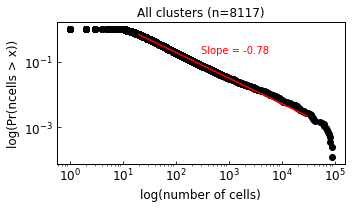

In [279]:
counts_sort = np.sort(sizes_all)
nclust = len(counts_sort)
Pr = np.array([r/nclust for r in range(nclust,0,-1)])

bool_l = counts_sort > 20
bool_u = counts_sort < 1e4
lnc = np.log(counts_sort[bool_l * bool_u])
lnp = np.log(Pr[bool_l * bool_u])
slope, intercept, r_value, p_value, std_err = stats.linregress(lnc, lnp)

fig, ax = ip.general_plot()
ax.scatter(counts_sort, Pr, color='k')

x = [2e1, 3e4]
y = math.exp(intercept) * x**slope
ax.plot(x, y, 'r')
x = 3e2
y = math.exp(intercept) * x**slope + 0.1
ax.text(x, y, 'Slope = ' + str(round(slope,2)), color='r')

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_title('All clusters (n=8117)')
ax.set_xlabel("log(number of cells)")
ax.set_ylabel("log(Pr(ncells > x))")
out_fn = cluster_size_dir + '/all_clusters_size_distribution.png'
ip.check_dir(out_fn)
ip.save_fig(out_fn)

Each image

In [289]:
dict_sn_clsizes = defaultdict(list)
for sn, dict_scn_clsize in dict_sn_scn_clsize.items():
    for scn, clsizes in dict_scn_clsize.items():
        dict_sn_clsizes[sn] += clsizes.tolist()

len(dict_sn_clsizes)

52

1.847962164367185 -0.759105466879928
300.0 0.08359176286755936
1.7742906923004453 -0.6794161088587778
300.0 0.12234002725250513
1.9755430031818426 -0.7898447201280787
300.0 0.07969412026981712
1.8733752555558287 -0.7727697003151233
300.0 0.0793144444063055


/home/bmg224/miniconda3/envs/hiprfish_pysal/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/bmg224/miniconda3/envs/hiprfish_pysal/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/bmg224/miniconda3/envs/hiprfish_pysal/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


1.7522074371254674 -0.6747990102261628
300.0 0.12286128413064447
1.6617640562864044 -0.7188055848665054
300.0 0.08732254156768758


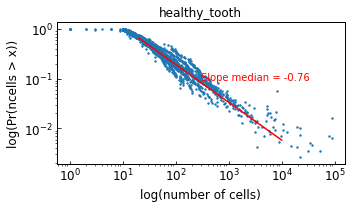

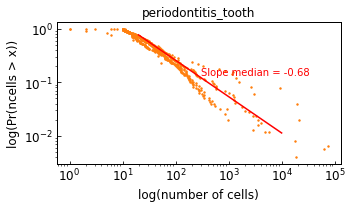

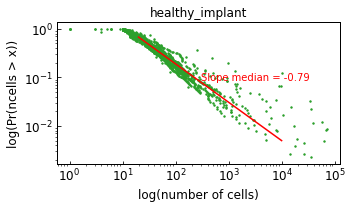

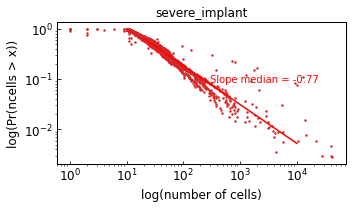

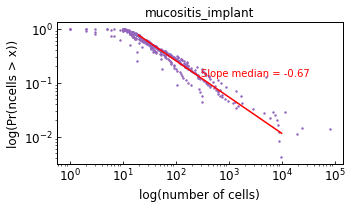

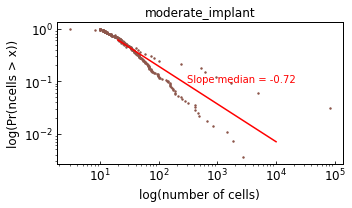

In [300]:
smin = 1e10
smax = -1e10

colors = plt.get_cmap('tab10').colors
dict_group_color = dict(zip(list(dict_group_sn.keys()), colors))

for group, sns in dict_group_sn.items():
    color = dict_group_color[group]
    fig, ax = ip.general_plot()
    slopes = []
    intercepts = []
    for sn in sns:
        clsizes = dict_sn_clsizes[sn]
        counts_sort = np.sort(clsizes)
        nclust = len(counts_sort)
        Pr = np.array([r / nclust for r in range(nclust, 0, -1)])

        bool_l = counts_sort > 20
        bool_u = counts_sort < 1e4
        lnc = np.log(counts_sort[bool_l * bool_u])
        lnp = np.log(Pr[bool_l * bool_u])
        slope, intercept, r_value, p_value, std_err = stats.linregress(lnc, lnp)
        if slope < smin: 
            smin = slope
            imin = intercept
        if slope > smax:
            smax = slope
            imax = intercept
        ax.scatter(counts_sort, Pr, s=2, color=color)

        slopes.append(slope)
        intercepts.append(intercept)

    slopes = np.array(slopes)
    slopes = slopes[~np.isnan(slopes)]
    intercepts = np.array(intercepts)
    intercepts = intercepts[~np.isnan(intercepts)]
    smean = np.median(slopes)
    imean = np.median(intercepts)
    x = [2e1, 1e4]
    y = math.exp(imean) * x**smean
    ax.plot(x, y, "r")
    x = 3e2
    y = (math.exp(imean) * x**smean) 
    print(imean, smean)
    print(x, y)
    ax.text(x, y, "Slope median = " + str(round(smean, 2)), color="r", ha="left", va="bottom")

    # x = [2e1, 1e4]
    # y = math.exp(imin) * x**smin
    # ax.plot(x, y, "r")
    # x = 3e2
    # y = (math.exp(imin) * x**smin) - 0.01
    # print(x, y)
    # ax.text(x, y, "Slope min = " + str(round(smin, 2)), color="r", ha='right', va='top')

    # x = [2e1, 1e4]
    # y = math.exp(imax) * x**smax
    # ax.plot(x, y, "r")
    # x = 3e2
    # y = math.exp(imax) * x**smax + 0.1
    # ax.text(x, y, "Slope max = " + str(round(smax, 2)), color="r", ha='left', va='bottom')
    # print(x,y)

    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_title(group)
    ax.set_xlabel("log(number of cells)")
    ax.set_ylabel("log(Pr(ncells > x))")

    out_fn = cluster_size_dir + '/size_distribution_by_sample_group_{}.png'.format(group)
    ip.check_dir(out_fn)
    ip.save_fig(out_fn)

Plot implants together

In [365]:
counts_sort

array([list([4, 33, 482, 10257, 249, 42, 40, 1]),
       list([6, 21, 28, 70, 673, 16, 31, 15, 89, 38, 24, 53, 75, 27, 123, 20, 15, 488, 49, 58, 17948, 21, 18, 14, 13, 434, 418, 16, 10, 147, 20, 41, 13, 38, 14, 27, 331, 18, 30, 33, 10, 39, 21, 20, 29, 33, 47, 50, 30, 102, 8180, 13, 189, 21, 515, 28, 10, 27, 48, 10, 28, 12, 18, 82, 25, 16, 25, 13, 15, 20, 23, 15, 74, 11, 18, 113, 76, 14, 51, 10, 26, 55, 27, 1111, 47, 57, 22, 121, 14, 26, 10, 143, 47, 11, 60, 60, 19, 14, 49, 22, 39, 56, 14, 41, 426, 18, 68, 42, 28, 13, 32, 57, 12, 309, 12, 42, 18, 20, 11, 18, 17, 10, 26, 13, 10, 16, 24, 503, 16, 142, 12, 39, 19, 38, 82, 151, 32, 98, 20, 113, 39, 21, 144, 25, 171, 33, 209, 22, 88, 153, 49, 16, 14, 30, 64, 123, 11, 49, 58, 12, 19, 14, 1552, 29, 24, 31, 107, 181, 17, 861, 15, 12, 16, 14, 10, 58, 70, 28, 1379, 906, 32, 17, 26, 59, 503, 58, 22, 134, 47, 29, 32, 113, 18, 32, 21, 64, 38, 12, 13, 23, 41, 15, 37, 73, 610, 20, 11, 27, 12, 12, 14, 16, 20, 13, 20, 13, 16, 15, 14, 33, 28, 15, 211, 20

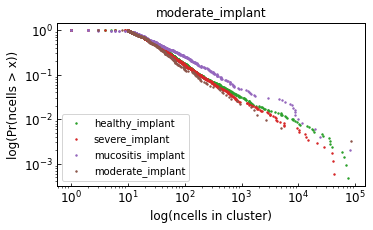

In [369]:
smin = 1e10
smax = -1e10

colors = plt.get_cmap("tab10").colors
dict_group_color = dict(zip(list(dict_group_sn.keys()), colors))
fig, ax = ip.general_plot()

for group, sns in dict_group_sn.items():
    if 'implant' in group:
        color = dict_group_color[group]
        clsizes = []
        for sn in sns:
            clsizes += dict_sn_clsizes[sn]

        counts_sort = np.sort(np.array(clsizes))
        nclust = len(counts_sort)
        Pr = np.array([r / nclust for r in range(nclust, 0, -1)])

        bool_l = counts_sort > 20
        bool_u = counts_sort < 1e4
        lnc = np.log(counts_sort[bool_l * bool_u])
        lnp = np.log(Pr[bool_l * bool_u])


        slope, intercept, r_value, p_value, std_err = stats.linregress(lnc, lnp)
        if slope < smin:
            smin = slope
            imin = intercept
        if slope > smax:
            smax = slope
            imax = intercept
        ax.scatter(counts_sort, Pr, s=2, color=color, label=group)

        # x = [2e1, 1e4]
        # y = math.exp(intercept) * x**slope
        # ax.plot(x, y, "r")
        # x = 3e2
        # y = math.exp(intercept) * x**slope
        # ax.text(
        #     x,
        #     y,
        #     "Slope = " + str(round(slope, 2)) + ", R^2 = " + str(round(r_value**2, 3)),
        #     color="r",
        #     ha="left",
        #     va="bottom",
        # )

        # x = [2e1, 1e4]
        # y = math.exp(imin) * x**smin
        # ax.plot(x, y, "r")
        # x = 3e2
        # y = (math.exp(imin) * x**smin) - 0.01
        # print(x, y)
        # ax.text(x, y, "Slope min = " + str(round(smin, 2)), color="r", ha='right', va='top')

        # x = [2e1, 1e4]
        # y = math.exp(imax) * x**smax
        # ax.plot(x, y, "r")
        # x = 3e2
        # y = math.exp(imax) * x**smax + 0.1
        # ax.text(x, y, "Slope max = " + str(round(smax, 2)), color="r", ha='left', va='bottom')
        # print(x,y)

        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.set_title(group)
        ax.set_xlabel("log(ncells in cluster)")
        ax.set_ylabel("log(Pr(ncells > x))")
ax.legend()
    # out_fn = cluster_size_dir + "/size_distribution_by_sample_group_{}.png".format(
    #     group
    # )
    # ip.check_dir(out_fn)
    # ip.save_fig(out_fn)

Plot each taxon

In [243]:
dict_scn_clsizes = defaultdict(list)
for sn, dict_scn_clsize in dict_sn_scn_clsize.items():
    for scn, clsizes in dict_scn_clsize.items():
        dict_scn_clsizes[scn] += clsizes.tolist()

len(dict_scn_clsizes)

19

300.0 0.16408414999454393


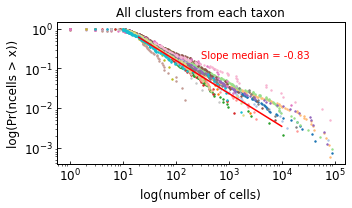

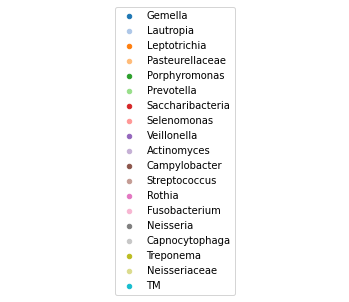

<Figure size 432x288 with 0 Axes>

In [280]:
smin = 1e10
smax = -1e10

colors = plt.get_cmap('tab20').colors

plots = []
slopes = []
intercepts = []
fig, ax = ip.general_plot()
for i, (sn, clsizes) in enumerate(dict_scn_clsizes.items()):
    counts_sort = np.sort(clsizes)
    nclust = len(counts_sort)
    Pr = np.array([r / nclust for r in range(nclust, 0, -1)])

    bool_l = counts_sort > 20
    bool_u = counts_sort < 1e4
    lnc = np.log(counts_sort[bool_l * bool_u])
    lnp = np.log(Pr[bool_l * bool_u])
    slope, intercept, r_value, p_value, std_err = stats.linregress(lnc, lnp)
    if slope < smin:
        smin = slope
        imin = intercept
    if slope > smax:
        smax = slope
        imax = intercept
    slopes.append(slope)
    intercepts.append(intercept)
    ax.scatter(counts_sort, Pr, s=2, label=sn, color=colors[i])

# x = [2e1, 1e4]
# y = math.exp(imin) * x**smin
# ax.plot(x, y, "r")
# x = 3e2
# y = (math.exp(imin) * x**smin) - 0.001
# print(x, y)
# ax.text(x, y, "Slope min = " + str(round(smin, 2)), color="r", ha="right", va="top")

# x = [2e1, 1e4]
# y = math.exp(imax) * x**smax
# ax.plot(x, y, "r")
# x = 3e2
# y = math.exp(imax) * x**smax + 0.1
# ax.text(x, y, "Slope max = " + str(round(smax, 2)), color="r", ha="left", va="bottom")
# print(x, y)

smean = np.median(slopes)
imean = np.median(intercepts)
x = [2e1, 1e4]
y = math.exp(imean) * x**smean
ax.plot(x, y, "r")
x = 3e2
y = (math.exp(imean) * x**smean) + 0.1
print(x, y)
ax.text(x, y, "Slope median = " + str(round(smean, 2)), color="r", ha="left", va="bottom")

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_title("All clusters from each taxon")
ax.set_xlabel("log(number of cells)")
ax.set_ylabel("log(Pr(ncells > x))")

plt.figure(fig)
out_fn = cluster_size_dir + '/all_taxa_clusters_size_distribution.png'
ip.check_dir(out_fn)
ip.save_fig(out_fn)

legendFig = plt.figure("Legend plot")
label_params = ax.get_legend_handles_labels()
figl, axl = plt.subplots()
axl.axis(False)
lgnd = axl.legend(*label_params, loc="center", bbox_to_anchor=(0.5, 0.5))
for l in lgnd.legendHandles:
    l._sizes = [20]

plt.figure(legendFig)
out_fn = cluster_size_dir + '/all_taxa_clusters_size_distribution_legend.png'
ip.check_dir(out_fn)
ip.save_fig(out_fn)

Plot slope for each taxon in each image

/home/bmg224/miniconda3/envs/hiprfish_pysal/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/bmg224/miniconda3/envs/hiprfish_pysal/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/bmg224/miniconda3/envs/hiprfish_pysal/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


Text(0, 0.5, 'Power law eponent for each tilescan')

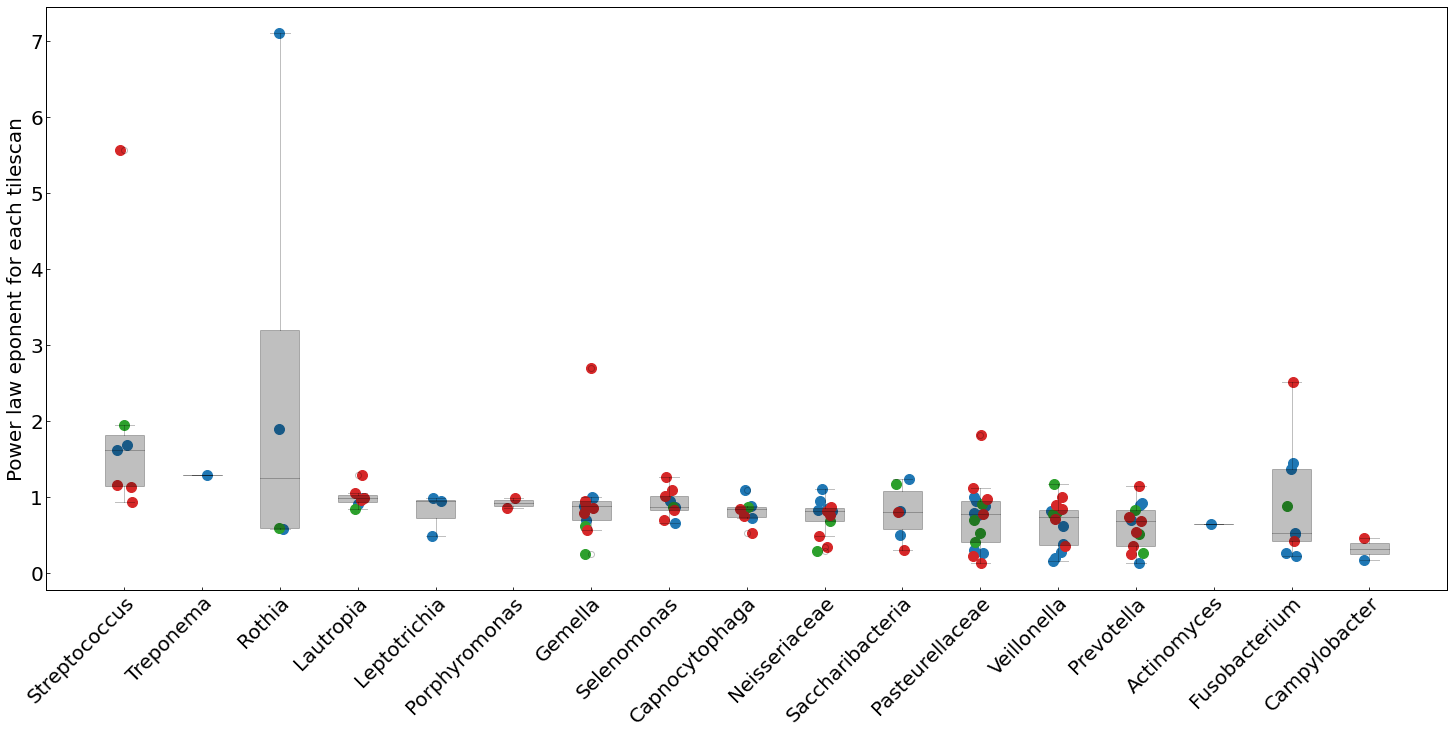

In [478]:
smin = 1e10
smax = -1e10

dict_group_sgroup = {
    "healthy_implant": "healthy",
    "severe_implant": "disease",
    "moderate_implant": "disease",
    "mucositis_implant": "disease",
    "periodontitis_tooth": "disease",
    "healthy_tooth": "healthy",
}

dict_scn_slopes = defaultdict(list)
dict_scn_groups = defaultdict(list)
for sn, dict_scn_clsize in dict_sn_scn_clsize.items():
    group = dict_sn_group[sn]
    if 'implant' in group:
        for scn, clsizes in dict_scn_clsize.items():
            if len(clsizes) > 3:
                if scn == "Neisseria":
                    scn = "Neisseriaceae"
                elif scn == "TM7":
                    scn = "Saccharibacteria"
                elif scn == "TM":
                    scn = "Saccharibacteria"

                # color = dict_sciname_color[scn]
                counts_sort = np.sort(np.array(clsizes))
                nclust = len(counts_sort)
                Pr = np.array([r / nclust for r in range(nclust, 0, -1)])

                bool_l = counts_sort > 20
                bool_u = counts_sort < 1e4
                lnc = np.log(counts_sort[bool_l * bool_u])
                lnp = np.log(Pr[bool_l * bool_u])

                slope, intercept, r_value, p_value, std_err = stats.linregress(lnc, lnp)
                if not np.isnan(slope):
                    dict_scn_slopes[scn].append(slope)
                    dict_scn_groups[scn].append(group)


means = [np.median(s) for s in dict_scn_slopes.values()]
scns = [s for s in dict_scn_slopes.keys()]
scns_sort = [x for _, x in sorted(zip(means, scns))]


xticks = np.arange(len(scns_sort)) + 1
dict_sciname_ind = dict(zip(scns_sort, xticks))
# dict_sciname_ind["Neisseria"] = dict_sciname_ind["Neisseriaceae"]
# dict_sciname_ind["Saccharibacteria"] = dict_sciname_ind["TM7"]
# dict_sciname_ind["TM"] = dict_sciname_ind["TM7"]

s=100

fig, ax = ip.general_plot(dims=(20,10), ft=20)
x = 1
# scn_list = []
# xticks = []
for scn in scns_sort:
    x = dict_sciname_ind[scn]
    slopes = dict_scn_slopes[scn]
    slopes = -np.array(slopes) 
    xs = [x] * len(slopes) + np.random.rand(len(slopes)) * 0.2 - 0.1
    color = dict_sciname_color[scn]
    # box = ax.boxplot([slopes], positions=[x], vert=True, widths=0.5)
    box = ax.boxplot([slopes], positions=[x], vert=True, widths=0.5, patch_artist=True)
    for k, vs in box.items():
        for v in vs:
            v.set_color('k')
            v.set_alpha(0.25)
            # if k == 'boxes':
            # v.set_facecolor("k")

    groups = np.array(dict_scn_groups[scn])

    ax.scatter(xs[groups == "healthy_implant"], slopes[groups == "healthy_implant"], color="tab:blue", s=s)
    ax.scatter(xs[groups == "mucositis_implant"], slopes[groups == "mucositis_implant"], color="tab:green", s=s)
    ax.scatter(xs[groups == "peri_implantitis"], slopes[groups == "peri_implantitis"], color="tab:red", s=s)


    
    x += 1

_ = ax.set_xticks(
    xticks, scns_sort, rotation=45, ha="right", va="top", rotation_mode="anchor"
)
ax.set_xlim(0,np.max(xticks) + 1)
ax.set_ylabel("Power law eponent for each tilescan")


# out_fn = cluster_size_dir + "/size_distribution_by_sample_group_{}.png".format(
#     group
# )
# ip.check_dir(out_fn)
# ip.save_fig(out_fn)

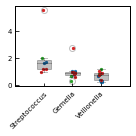

In [484]:

toplot = ['Streptococcus','Gemella','Neisseriaceeae','Veillonella']

s=5

fig, ax = ip.general_plot(dims=(2,2), ft=7)
x = 1
scn_list = []
xticks = []
for scn in scns_sort:
    if scn in toplot:
        # x = dict_sciname_ind[scn]
        slopes = dict_scn_slopes[scn]
        slopes = -np.array(slopes) 
        xs = [x] * len(slopes) + np.random.rand(len(slopes)) * 0.2 - 0.1
        color = dict_sciname_color[scn]
        # box = ax.boxplot([slopes], positions=[x], vert=True, widths=0.5)
        box = ax.boxplot([slopes], positions=[x], vert=True, widths=0.5, patch_artist=True)
        for k, vs in box.items():
            for v in vs:
                v.set_color('k')
                v.set_alpha(0.25)
                # if k == 'boxes':
                # v.set_facecolor("k")

        groups = np.array(dict_scn_groups[scn])

        ax.scatter(xs[groups == "healthy_implant"], slopes[groups == "healthy_implant"], color="tab:blue", s=s)
        ax.scatter(xs[groups == "mucositis_implant"], slopes[groups == "mucositis_implant"], color="tab:green", s=s)
        ax.scatter(xs[groups == "peri_implantitis"], slopes[groups == "peri_implantitis"], color="tab:red", s=s)

        scn_list.append(scn)
        xticks.append(x)
        
        x += 1

_ = ax.set_xticks(
    xticks, scn_list, rotation=45, ha="right", va="top", rotation_mode="anchor"
)
ax.set_xlim(0,np.max(xticks) + 1)
# ax.set_ylabel("Power law eponent for each tilescan")


out_fn = cluster_size_dir + "/size_distribution_boxplot_select.png"
ip.check_dir(out_fn)
ip.save_fig(out_fn)

In [485]:
out_fn

'../outputs/segmentation_2024_03_07/compare_samples/cluster_size_distribution/size_distribution_boxplot_select.png'

Plot slope for each sciname in each group

/home/bmg224/miniconda3/envs/hiprfish_pysal/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/bmg224/miniconda3/envs/hiprfish_pysal/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/bmg224/miniconda3/envs/hiprfish_pysal/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


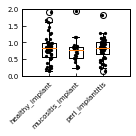

In [488]:
smin = 1e10
smax = -1e10


dict_group_slopes = defaultdict(list)
for sn, dict_scn_clsize in dict_sn_scn_clsize.items():
    group = dict_sn_group[sn]
    if 'implant' in group:
        for scn, clsizes in dict_scn_clsize.items():
            if len(clsizes) > 3:


                # color = dict_sciname_color[scn]
                counts_sort = np.sort(np.array(clsizes))
                nclust = len(counts_sort)
                Pr = np.array([r / nclust for r in range(nclust, 0, -1)])

                bool_l = counts_sort > 20
                bool_u = counts_sort < 1e4
                lnc = np.log(counts_sort[bool_l * bool_u])
                lnp = np.log(Pr[bool_l * bool_u])

                slope, intercept, r_value, p_value, std_err = stats.linregress(lnc, lnp)
                if not np.isnan(slope):
                    dict_group_slopes[group].append(slope)
            # x = dict_sciname_ind[scn] + np.random.rand()*0.5 - 0.25 + 1
            # ax.scatter([x], [-slope], s=2, color=color)

scns_sort = ['healthy_implant', 'mucositis_implant', 'peri_implantitis']

xticks = np.arange(len(scns_sort)) + 1
dict_sciname_ind = dict(zip(scns_sort, xticks))
# dict_sciname_ind["Neisseria"] = dict_sciname_ind["Neisseriaceae"]
# dict_sciname_ind["Saccharibacteria"] = dict_sciname_ind["TM7"]
# dict_sciname_ind["TM"] = dict_sciname_ind["TM7"]

s=5

fig, ax = ip.general_plot(dims=(2,2), ft=7)

for scn in scns_sort:
    x = dict_sciname_ind[scn]
    slopes = dict_group_slopes[scn]
    slopes = -np.array(slopes) 
    xs = [x] * len(slopes) + np.random.rand(len(slopes)) * 0.2 - 0.1
    # color = dict_sciname_color[scn]
    box = ax.boxplot([slopes], positions=[x], vert=True, widths=0.5)

    ax.scatter(xs, slopes, color='k', s=s)

_ = ax.set_xticks(
    xticks, scns_sort, rotation=45, ha="right", va="top", rotation_mode="anchor"
)
ax.set_xlim(0,np.max(xticks) + 1)
ax.set_ylim(0,2)
# ax.set_ylabel('Power law eponent for each tilescan')

out_fn = cluster_size_dir + "/size_distribution_boxplot_bygroup.png".format(
    group
)
ip.check_dir(out_fn)
ip.save_fig(out_fn)

Plot slope for each tilescan in each group

/home/bmg224/miniconda3/envs/hiprfish_pysal/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/bmg224/miniconda3/envs/hiprfish_pysal/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/bmg224/miniconda3/envs/hiprfish_pysal/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


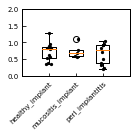

In [666]:
smin = 1e10
smax = -1e10


dict_group_slopes = defaultdict(list)
for sn, clsizes in dict_sn_clsizes.items():
    group = dict_sn_group[sn]
    if 'implant' in group:
        if len(clsizes) > 3:


            # color = dict_sciname_color[scn]
            counts_sort = np.sort(np.array(clsizes))
            nclust = len(counts_sort)
            Pr = np.array([r / nclust for r in range(nclust, 0, -1)])

            bool_l = counts_sort > 20
            bool_u = counts_sort < 1e4
            lnc = np.log(counts_sort[bool_l * bool_u])
            lnp = np.log(Pr[bool_l * bool_u])

            slope, intercept, r_value, p_value, std_err = stats.linregress(lnc, lnp)
            if not np.isnan(slope):
                dict_group_slopes[group].append(slope)
        # x = dict_sciname_ind[scn] + np.random.rand()*0.5 - 0.25 + 1
        # ax.scatter([x], [-slope], s=2, color=color)

scns_sort = ['healthy_implant', 'mucositis_implant', 'peri_implantitis']

xticks = np.arange(len(scns_sort)) + 1
dict_sciname_ind = dict(zip(scns_sort, xticks))
# dict_sciname_ind["Neisseria"] = dict_sciname_ind["Neisseriaceae"]
# dict_sciname_ind["Saccharibacteria"] = dict_sciname_ind["TM7"]
# dict_sciname_ind["TM"] = dict_sciname_ind["TM7"]

s=5

fig, ax = ip.general_plot(dims=(2,2), ft=7)

for scn in scns_sort:
    x = dict_sciname_ind[scn]
    slopes = dict_group_slopes[scn]
    slopes = -np.array(slopes) 
    xs = [x] * len(slopes) + np.random.rand(len(slopes)) * 0.2 - 0.1
    # color = dict_sciname_color[scn]
    box = ax.boxplot([slopes], positions=[x], vert=True, widths=0.5)

    ax.scatter(xs, slopes, color='k', s=s)

_ = ax.set_xticks(
    xticks, scns_sort, rotation=45, ha="right", va="top", rotation_mode="anchor"
)
ax.set_xlim(0,np.max(xticks) + 1)
ax.set_ylim(0,2)
# ax.set_ylabel('Power law eponent for each tilescan')

out_fn = cluster_size_dir + "/size_distribution_boxplot_tiles_bygroup.png".format(
    group
)
ip.check_dir(out_fn)
ip.save_fig(out_fn)

In [602]:
(np.log(36) - np.log(9)) / (np.log(4) - np.log(8))

-2.0

In [418]:
scns_sort

['Rothia',
 'Streptococcus',
 'Treponema',
 'Capnocytophaga',
 'Lautropia',
 'Porphyromonas',
 'Selenomonas',
 'Saccharibacteria',
 'Fusobacterium',
 'Leptotrichia',
 'Pasteurellaceae',
 'Veillonella',
 'Gemella',
 'Actinomyces',
 'Neisseriaceae',
 'Prevotella',
 'Campylobacter']

##  Count things

In [312]:
out_dir = "../outputs/segmentation_2024_03_07/{date}/{date}_{sn}"

out_dir_seg = out_dir + '/segs'
props_fmt = out_dir_seg + "/{date}_{sn}_M_{m}_props.csv"

spatial_dir = out_dir + '/spatial_statistics'
cl_size_dir = spatial_dir + '/cluster_size'
cluster_size_fmt = cl_size_dir + '/{date}_{sn}_sciname_{scn}_cluster_size.npy'

In [314]:
dict_group_counts = defaultdict(dict)
for group, sns in dict_group_sn.items():
    n_tiles = 0
    n_cells = 0 
    n_clusters = 0
    for s in sns:
        date, sn = re.split("(?<=^\d{4}_\d{2}_\d{2})_", s)
        props_glob = props_fmt.format(date=date, sn=sn, m='*')
        props_fns = glob.glob(props_glob)
        n_tiles += len(props_fns)
        for pfn in props_fns:
            prop = pd.read_csv(pfn)
            n_cells += prop.shape[0]
        
        cl_glob = cluster_size_fmt.format(date=date, sn=sn, scn='*')
        cl_fns = glob.glob(cl_glob)
        for fn in cl_fns:
            clust = np.load(fn)
            n_clusters += len(np.unique(clust))
    dict_group_counts[group]['tiles'] = n_tiles
    dict_group_counts[group]['cells'] = n_cells
    dict_group_counts[group]['clusters'] = n_clusters

dict_group_counts

        

defaultdict(dict,
            {'healthy_tooth': {'tiles': 108,
              'cells': 1052390,
              'clusters': 2808},
             'periodontitis_tooth': {'tiles': 33,
              'cells': 345460,
              'clusters': 643},
             'healthy_implant': {'tiles': 83,
              'cells': 924269,
              'clusters': 2129},
             'severe_implant': {'tiles': 48,
              'cells': 469839,
              'clusters': 1730},
             'mucositis_implant': {'tiles': 28,
              'cells': 287250,
              'clusters': 492},
             'moderate_implant': {'tiles': 13,
              'cells': 122337,
              'clusters': 315}})

In [322]:
a = pd.DataFrame(dict_group_counts).T
a

,tiles,cells,clusters
healthy_tooth,108,1052390,2808
periodontitis_tooth,33,345460,643
healthy_implant,83,924269,2129
severe_implant,48,469839,1730
mucositis_implant,28,287250,492
moderate_implant,13,122337,315


In [323]:
a.tiles.sum()

313

In [324]:
a.cells.sum()

3201545

In [325]:
a.clusters.sum()

8117

## Box counting dimension

In [330]:
print(scn_unq)

['Gemella' 'Lautropia' 'Leptotrichia' 'Pasteurellaceae' 'Porphyromonas'
 'Prevotella' 'Saccharibacteria' 'Selenomonas' 'Veillonella']


In [334]:
window.bbox

[5.67816091954023, 890.4777777777778, 5796.403846153846, 5795.411764705883]

In [335]:
np.argmin([1,2])

0

/home/bmg224/miniconda3/envs/hiprfish_pysal/lib/python3.7/site-packages/libpysal/cg/shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/home/bmg224/miniconda3/envs/hiprfish_pysal/lib/python3.7/site-packages/libpysal/cg/shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/home/bmg224/miniconda3/envs/hiprfish_pysal/lib/python3.7/site-packages/libpysal/cg/shapes.py:1923: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


Gemella
-1.5838250245774792


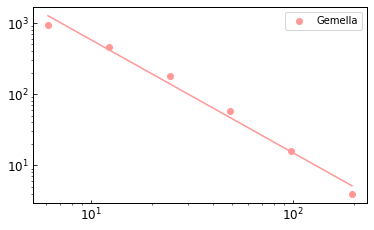

Lautropia
-1.622798454882617


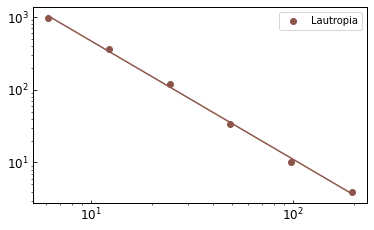

Leptotrichia
-1.4112823419523333


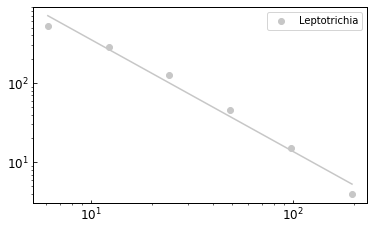

Pasteurellaceae
-1.783686275081797


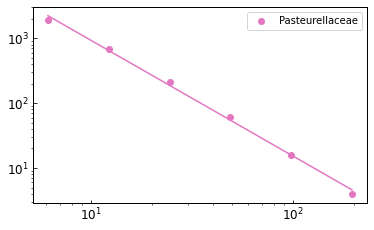

Porphyromonas
-0.9924331698448773


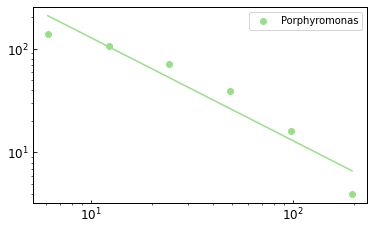

Saccharibacteria
-1.1330556309633948


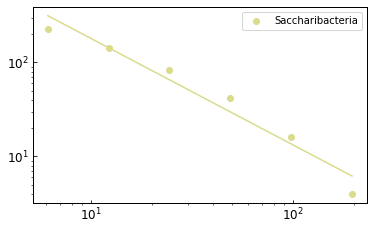

Selenomonas
-0.9990158773735182


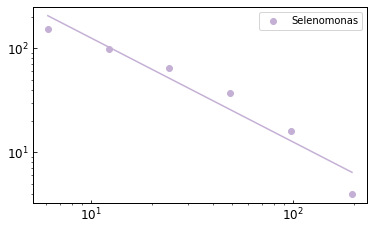

Veillonella
-1.747295532404176


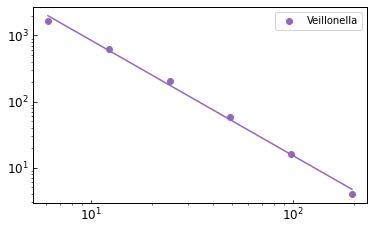

In [527]:
# Get cells window
convex_hull = ps.cg.convex_hull(coords.tolist())
ch_arr = np.array(to_ccf(convex_hull))
# plt.plot(ch_arr[:, 1], ch_arr[:, 0])
# plt.gca().invert_yaxis()
window = Window([convex_hull])

# Get boxes initial
bbox = window.bbox
w_shp = [bbox[2] - bbox[0], bbox[3] - bbox[1]]
dmin = np.min(w_shp)
dmax = np.max(w_shp)
ind_dmin = np.argmin(w_shp)
ind_dmax = np.argmax(w_shp)
dim_xy_init = np.array([0,0])
dim_xy_init[ind_dmin] = 2
ndmax = int(math.ceil(dmax / dmin))
dim_xy_init[ind_dmax] = ndmax
dmax_i_um_init = dmax / dim_xy_init[ind_dmax] * res_umpix

# # Get hexagon length initial
# lh_init = 100

# minimum box size um
dmiu_min = 5

slopes = []
for scn in scn_unq:
    if scn != 'Prevotella':
        fig, ax = ip.general_plot()
        print(scn)
        # Get point pattern
        col_obs = dict_sciname_color[scn]
        bool_scn = scinames == scn
        coord_scn = coords[bool_scn]
        pp = PointPattern(coord_scn, window=window)

        # Get qstatistic
        dxy = dim_xy_init.copy()
        dmax_i_um = dmax_i_um_init.copy()
        counts = []
        box_size = []
        while dmax_i_um > dmiu_min:
            # q_r = qs.QStatistic(pp, shape="rectangle", nx=dxy[1], ny=dxy[0])
            # lh = lh_init
            # q_r = qs.QStatistic(pp, shape="hexagon", lh=lh)
            # q_r.plot()
            rect = RectangleM(pp, dxy[1], dxy[0]).point_location_sta()
            c = np.array(list(rect.values()))
            count = sum(c > 0)
            counts.append(count)
            box_size.append(dmax_i_um)

            dxy *= 2
            dmax_i_um = dmax / dxy[ind_dmax] * res_umpix

        # Get regression
        lnc = np.log(counts)
        lns = np.log(box_size)
        slope, intercept, r_value, p_value, std_err = stats.linregress(lns, lnc)
        print(slope)
        slopes.append(-slope)


        ax.scatter(box_size, counts, color=col_obs, label=scn)

    
        x = np.array([min(box_size), max(box_size)])
        y = math.exp(intercept) * x**slope
        ax.plot(x, y, color=col_obs)
        x = 40
        y = math.exp(intercept) * x**slope
        # ax.text(
        #     x,
        #     y,
        #     "Slope = " + str(round(smean, 2)) + ", R^2 = " + str(round(r_value**2, 3)),
        #     color="r",
        #     ha="left",
        #     va="bottom",
        # )


        ax.set_xscale("log")
        ax.set_yscale("log")
        plt.legend()
        plt.show()
        plt.close()



In [528]:
np.sqrt(np.sum(np.array([3,4])**2))

5.0

/home/bmg224/miniconda3/envs/hiprfish_pysal/lib/python3.7/site-packages/libpysal/cg/shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/home/bmg224/miniconda3/envs/hiprfish_pysal/lib/python3.7/site-packages/libpysal/cg/shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/home/bmg224/miniconda3/envs/hiprfish_pysal/lib/python3.7/site-packages/libpysal/cg/shapes.py:1923: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


Gemella
-1.3460869938988484 0.9909437343763131


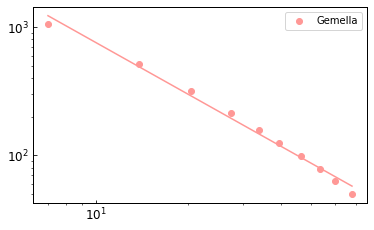

Lautropia
-1.6010794587968722 0.9936614385137524


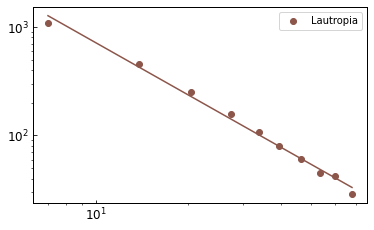

Leptotrichia
-1.16506675948727 0.9845330363874393


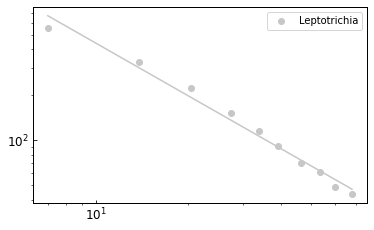

Pasteurellaceae
-1.6627926059746698 0.9968690030393196


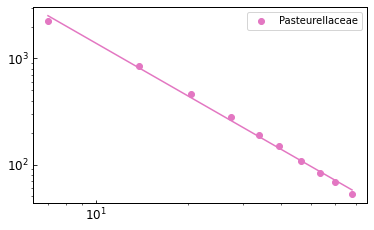

Porphyromonas
-0.6106988922288535 0.9819812504086957


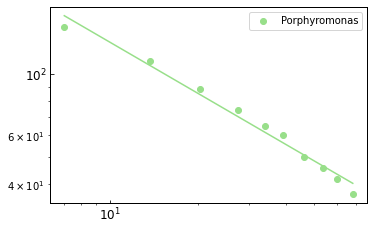

Prevotella
-1.8997004343214217 0.9997506275360991


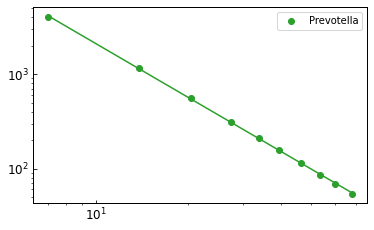

Saccharibacteria
-0.8064975251238621 0.9850717024337121


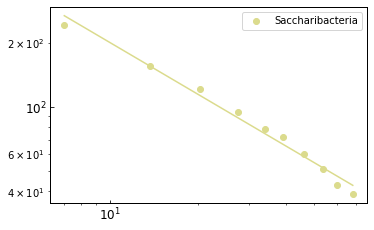

Selenomonas
-0.6852747928022176 0.9734989819545266


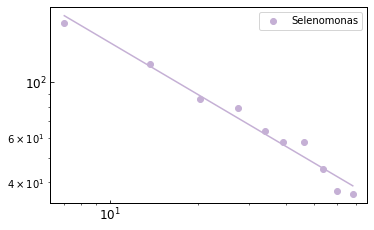

Veillonella
-1.600848534119901 0.9963974562565195


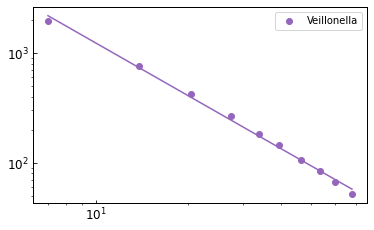

In [535]:
# Get cells window
convex_hull = ps.cg.convex_hull(coords.tolist())
ch_arr = np.array(to_ccf(convex_hull))
# plt.plot(ch_arr[:, 1], ch_arr[:, 0])
# plt.gca().invert_yaxis()
window = Window([convex_hull])

# Get boxes initial
bbox = window.bbox
w_shp = np.array([bbox[2] - bbox[0], bbox[3] - bbox[1]])
box_edge_init_um = 50
box_edge_init = box_edge_init_um / res_umpix
box_edge_min_um = 5
box_edge_min = box_edge_min_um / res_umpix

# dmin = np.min(w_shp)
# dmax = np.max(w_shp)
# ind_dmin = np.argmin(w_shp)
# ind_dmax = np.argmax(w_shp)
# dim_xy_init = np.array([0,0])
# dim_xy_init[ind_dmin] = 2
# ndmax = int(math.ceil(dmax / dmin))
# dim_xy_init[ind_dmax] = ndmax
# dmax_i_um_init = dmax / dim_xy_init[ind_dmax] * res_umpix

# # Get hexagon length initial
# lh_init = 100

# minimum box size um
# dmiu_min = 5

slopes = []
for scn in scn_unq:
    # if scn != 'Prevotella':
    fig, ax = ip.general_plot()
    print(scn)
    # Get point pattern
    col_obs = dict_sciname_color[scn]
    bool_scn = scinames == scn
    coord_scn = coords[bool_scn]
    pp = PointPattern(coord_scn, window=window)

    # Get qstatistic
    box_edge_um = box_edge_init_um
    counts = []
    box_size = []
    while box_edge_um >= box_edge_min_um:
        box_edge = box_edge_um / res_umpix
        nxy = np.ceil(w_shp / box_edge).astype(int)
        # q_r = qs.QStatistic(pp, shape="rectangle", nx=dxy[1], ny=dxy[0])
        # lh = lh_init
        # q_r = qs.QStatistic(pp, shape="hexagon", lh=lh)
        # q_r.plot()
        rect = RectangleM(pp, nxy[1], nxy[0]).point_location_sta()
        c = np.array(list(rect.values()))
        count = sum(c > 0)
        counts.append(count)
        dxy = w_shp / nxy
        diag = np.sqrt(np.sum(dxy**2))
        diag_um = diag * res_umpix
        box_size.append(diag_um)

        box_edge_um -= 5

    # Get regression
    lnc = np.log(counts)
    lns = np.log(box_size)
    slope, intercept, r_value, p_value, std_err = stats.linregress(lns, lnc)
    print(slope, r_value**2)
    slopes.append(-slope)


    ax.scatter(box_size, counts, color=col_obs, label=scn)


    x = np.array([min(box_size), max(box_size)])
    y = math.exp(intercept) * x**slope
    ax.plot(x, y, color=col_obs)
    x = 40
    y = math.exp(intercept) * x**slope
    # ax.text(
    #     x,
    #     y,
    #     "Slope = " + str(round(smean, 2)) + ", R^2 = " + str(round(r_value**2, 3)),
    #     color="r",
    #     ha="left",
    #     va="bottom",
    # )


    ax.set_xscale("log")
    ax.set_yscale("log")
    plt.legend()
    plt.show()
    plt.close()



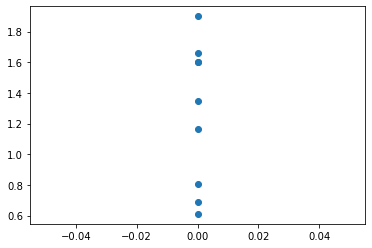

In [540]:
x = np.array([0]*len(slopes)) 
plt.scatter(x, slopes)

## Measure of homogeneity

Define new function for Rectangle class

In [618]:
class RectangleM_new:
    """
    Rectangle grid structure for quadrat-based method.

    Parameters
    ----------
    pp                : :class:`.PointPattern`
                        Point Pattern instance.
    count_column      : integer
                        Number of rectangles in the horizontal
                        direction. Use in pair with count_row to
                        fully specify a rectangle. Incompatible with
                        rectangle_width and rectangle_height.
    count_row         : integer
                        Number of rectangles in the vertical
                        direction. Use in pair with count_column to
                        fully specify a rectangle. Incompatible with
                        rectangle_width and rectangle_height.
    rectangle_width   : float
                        Rectangle width. Use in pair with
                        rectangle_height to fully specify a rectangle.
                        Incompatible with count_column & count_row.
    rectangle_height  : float
                        Rectangle height. Use in pair with
                        rectangle_width to fully specify a rectangle.
                        Incompatible with count_column & count_row.

    Attributes
    ----------
    pp                : :class:`.PointPattern`
                        Point Pattern instance.
    mbb               : array
                        Minimum bounding box for the point pattern.
    points            : array
                        x,y coordinates of the point points.
    count_column      : integer
                        Number of columns.
    count_row         : integer
                        Number of rows.
    num               : integer
                        Number of rectangular quadrats.

    """

    def __init__(self, pp, labels, count_column = 3, count_row = 3,
                 rectangle_width = 0, rectangle_height = 0):
        self.mbb = pp.mbb
        self.pp = pp
        self.points = np.asarray(pp.points)
        self.labels = np.array(labels)
        x_range = self.mbb[2]-self.mbb[0]
        y_range = self.mbb[3]-self.mbb[1]
        if rectangle_width & rectangle_height:
            self.rectangle_width = rectangle_width
            self.rectangle_height = rectangle_height

            # calculate column count and row count
            self.count_column = int(math.ceil(x_range / rectangle_width))
            self.count_row = int(math.ceil(y_range / rectangle_height))
        else:
            self.count_column = count_column
            self.count_row = count_row

            # calculate the actual width and height of cell
            self.rectangle_width = x_range/float(count_column)
            self.rectangle_height = y_range/float(count_row)
        self.num = self.count_column * self.count_row


    def point_location_sta(self):
        """
        Count the point events in each cell.

        Returns
        -------
        dict_id_count : dict
                        keys: rectangle id, values: number of point
                        events in each cell.
        """

        dict_id_count = {}
        for i in range(self.count_row):
            for j in range(self.count_column):
                dict_id_count[j+i*self.count_column] = 0

        for point in self.points:
            index_x = (point[0]-self.mbb[0]) // self.rectangle_width
            index_y = (point[1]-self.mbb[1]) // self.rectangle_height
            if index_x == self.count_column:
                index_x -= 1
            if index_y == self.count_row:
                index_y -= 1
            id = index_y * self.count_column + index_x
            dict_id_count[id] += 1
        return dict_id_count

    def _get_dict_id_labels(self):
        """
        Get a list of labels in each cell.

        Returns
        -------
        dict_id_count : dict
                        keys: rectangle id, values: number of point
                        events in each cell.
        """

        # dict_id_count = {}
        # for i in range(self.count_row):
        #     for j in range(self.count_column):
        #         dict_id_points[j+i*self.count_column] = []
        dict_id_labels = defaultdict(list)
        for point, lab in zip(self.points, self.labels):
            index_x = (point[0]-self.mbb[0]) // self.rectangle_width
            index_y = (point[1]-self.mbb[1]) // self.rectangle_height
            if index_x == self.count_column:
                index_x -= 1
            if index_y == self.count_row:
                index_y -= 1
            id = index_y * self.count_column + index_x
            dict_id_labels[id].append(lab)
        self.dict_id_labels = dict_id_labels

    def get_shannon_diversities(self):
        self._get_dict_id_labels()
        dict_idx_shannon = {}
        for idx, labels in self.dict_id_labels.items():
            labels = np.array(labels)
            nlab = len(labels)
            Hs = []
            for l in np.unique(labels):
                nl = sum(labels==l)
                p = nl / nlab
                Hs.append(p * np.log(p))
            H = -np.sum(Hs)
            dict_idx_shannon[idx] = H
        return dict_idx_shannon

    def get_simpson_diversities(self):
        self._get_dict_id_labels()
        dict_idx_simpson = {}
        for idx, labels in self.dict_id_labels.items():
            labels = np.array(labels)
            nlab = len(labels)
            if nlab > 1:
                etas = []
                for l in np.unique(labels):
                    nl = sum(labels==l)
                    etas.append(nl*(nl-1))
                D = 1 - np.sum(etas) / (nlab*(nlab-1))
            else:
                D = 0
            dict_idx_simpson[idx] = D
        return dict_idx_simpson

    def get_multispecies_tiles(self):
        self._get_dict_id_labels()
        dict_idx_multi = {}
        for idx, labels in self.dict_id_labels.items():
            c = 0
            if len(np.unique(labels)) > 1:
                c = 1
            dict_idx_multi[idx] = c
        return dict_idx_multi


In [611]:
labels = np.array([])
nlab = len(labels)
etas = []
for l in np.unique(labels):
    nl = sum(labels==l)
    etas.append(nl*(nl-1))
D = 1 - np.sum(etas) / (nlab*(nlab-1))
D

0.0

Do fuzzy box counting on shannon diversity

/home/bmg224/miniconda3/envs/hiprfish_pysal/lib/python3.7/site-packages/libpysal/cg/shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/home/bmg224/miniconda3/envs/hiprfish_pysal/lib/python3.7/site-packages/libpysal/cg/shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/home/bmg224/miniconda3/envs/hiprfish_pysal/lib/python3.7/site-packages/libpysal/cg/shapes.py:1923: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


50
47.329889594562154
33.333333333333336
92.6784138802462
22.222222222222225
191.4414349245246
14.814814814814817
392.1369620939396
9.876543209876544
797.488447159536
6.584362139917697
1611.2603897077508
-1.8512621440854118 0.9998973410147702


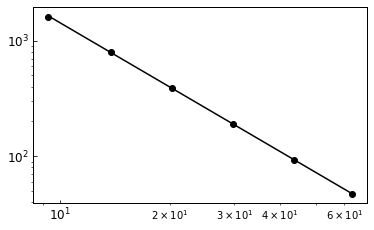

4.389574759945131


In [623]:
date = "2023_02_08"
sn = "hsdm_group_1_sample_12_fov_01"

centroid_sciname_fn = centroid_sciname_fmt.format(date=date, sn=sn)
centroid_sciname = pd.read_csv(centroid_sciname_fn)
coords = np.array([eval(c) for c in centroid_sciname["coord"].values])
scinames = centroid_sciname["sciname"].values
scn_unq = np.unique(scinames)

# Get cells window
convex_hull = ps.cg.convex_hull(coords.tolist())
ch_arr = np.array(to_ccf(convex_hull))
# plt.plot(ch_arr[:, 1], ch_arr[:, 0])
# plt.gca().invert_yaxis()
window = Window([convex_hull])

# Get boxes initial
bbox = window.bbox
# w_shp = np.array([bbox[2] - bbox[0], bbox[3] - bbox[1]])
box_edge_init_um = 50
div_edgesize = 1.5
box_edge_min_um = 5
col='k'

# if scn != 'Prevotella':
fig, ax = ip.general_plot()
# Get point pattern
pp = PointPattern(coords, window=window)

# Get qstatistic
box_edge_um = box_edge_init_um
counts = []
box_size = []
while box_edge_um >= box_edge_min_um:
    print(box_edge_um)
    box_edge = box_edge_um / res_umpix
    nxy = np.ceil(w_shp / box_edge).astype(int)

    rect = RectangleM_new(
        pp, 
        count_column = nxy[1], 
        count_row = nxy[1],
        labels=scinames
    ).get_simpson_diversities()
    Hs = np.array(list(rect.values()))
    count = sum(Hs)
    print(count)
    counts.append(count)
    dxy = w_shp / nxy
    diag = np.sqrt(np.sum(dxy**2))
    diag_um = diag * res_umpix
    box_size.append(diag_um)

    box_edge_um /= div_edgesize

# Get regression
lnc = np.log(counts)
lns = np.log(box_size)
slope, intercept, r_value, p_value, std_err = stats.linregress(lns, lnc)
print(slope, r_value**2)
slopes.append(-slope)


ax.scatter(box_size, counts, color=col, label=scn)


x = np.array([min(box_size), max(box_size)])
y = math.exp(intercept) * x**slope
ax.plot(x, y, color=col)
x = 40
y = math.exp(intercept) * x**slope
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()
plt.close()

print(box_edge_um)

In [624]:
sum(Hs == 0) / len(Hs)

0.08595571095571096

/home/bmg224/miniconda3/envs/hiprfish_pysal/lib/python3.7/site-packages/libpysal/cg/shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/home/bmg224/miniconda3/envs/hiprfish_pysal/lib/python3.7/site-packages/libpysal/cg/shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/home/bmg224/miniconda3/envs/hiprfish_pysal/lib/python3.7/site-packages/libpysal/cg/shapes.py:1923: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


-1.78767224756118 0.9999624579087654


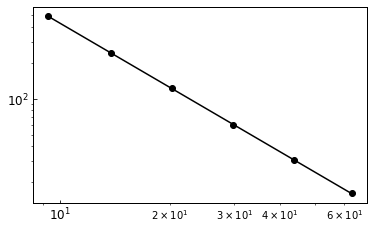

In [620]:
date = "2023_10_18"
sn = "hsdm_slide_IIL_fov_01"

centroid_sciname_fn = centroid_sciname_fmt.format(date=date, sn=sn)
centroid_sciname = pd.read_csv(centroid_sciname_fn)
coords = np.array([eval(c) for c in centroid_sciname["coord"].values])
scinames = centroid_sciname["sciname"].values
scn_unq = np.unique(scinames)

# Get cells window
convex_hull = ps.cg.convex_hull(coords.tolist())
ch_arr = np.array(to_ccf(convex_hull))
# plt.plot(ch_arr[:, 1], ch_arr[:, 0])
# plt.gca().invert_yaxis()
window = Window([convex_hull])

# Get boxes initial
bbox = window.bbox
w_shp = np.array([bbox[2] - bbox[0], bbox[3] - bbox[1]])
box_edge_init_um = 50
div_edgesize = 1.5
box_edge_min_um = 5
col='k'

# if scn != 'Prevotella':
fig, ax = ip.general_plot()
# Get point pattern
pp = PointPattern(coords, window=window)

# Get qstatistic
box_edge_um = box_edge_init_um
counts = []
box_size = []
while box_edge_um >= box_edge_min_um:
    box_edge = box_edge_um / res_umpix
    nxy = np.ceil(w_shp / box_edge).astype(int)

    rect = RectangleM_new(
        pp, 
        count_column = nxy[1], 
        count_row = nxy[1],
        labels=scinames
    ).get_simpson_diversities()
    # ).get_shannon_diversities()
    Hs = np.array(list(rect.values()))
    count = sum(Hs)
    counts.append(count)
    dxy = w_shp / nxy
    diag = np.sqrt(np.sum(dxy**2))
    diag_um = diag * res_umpix
    box_size.append(diag_um)

    box_edge_um /= div_edgesize

# Get regression
lnc = np.log(counts)
lns = np.log(box_size)
slope, intercept, r_value, p_value, std_err = stats.linregress(lns, lnc)
print(slope, r_value**2)
slopes.append(-slope)


ax.scatter(box_size, counts, color=col, label=scn)


x = np.array([min(box_size), max(box_size)])
y = math.exp(intercept) * x**slope
ax.plot(x, y, color=col)
x = 40
y = math.exp(intercept) * x**slope
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()
plt.close()



In [621]:
sum(Hs == 0) / len(Hs)

0.5179183546276098

### After running box counting on all

fuzzy box counting

In [656]:
fuzzy_box_count_all_fn = sample_compare_dir + '/fuzzy_box_counting_table.csv'
fuzzy_box_count_all = pd.read_csv(fuzzy_box_count_all_fn, index_col=0)
fuzzy_box_count_all

,slope,intercept,r_value,r_squared,p_value,std_err
2023_10_18_hsdm_slide_IIL_fov_01,-1.779956,9.948834,-0.999957,0.999915,2.720695e-09,0.008214
2023_10_18_hsdm_slide_IIIB_fov_01,-1.770596,10.200851,-0.999703,0.999406,1.323946e-07,0.021585
2023_10_18_hsdm_slide_IIIL_fov_01,-1.826439,9.633612,-0.999983,0.999965,4.493526e-10,0.005373
2023_02_18_hsdm_group_batch2_patient_11_fov_01,-1.873809,10.807734,-0.999985,0.999970,3.374020e-10,0.005131
2023_02_18_hsdm_group_batch1_patient_1_fov_01,-1.872878,9.252637,-0.999914,0.999828,1.107464e-08,0.012277
2023_02_18_hsdm_group_batch1_patient_1_fov_02,-1.824751,6.891432,-0.998512,0.997026,3.319525e-06,0.049828
2023_02_18_hsdm_group_batch1_patient_2_fov_01,-1.852098,11.174129,-0.999999,0.999999,5.752185e-13,0.001031
2023_02_18_hsdm_group_batch1_patient_3_fov_01,-1.866717,11.464480,-0.999919,0.999837,9.948532e-09,0.011913
2023_02_18_hsdm_group_batch1_patient_4_fov_01,-1.917276,8.543660,-0.999985,0.999970,3.449595e-10,0.005280
2023_02_18_hsdm_group_batch1_patient_7_fov_01,-1.967938,9.930978,-0.999999,0.999998,1.429550e-12,0.001375


In [662]:
exclude_sns = [
    '2023_10_16_hsdm_slide_IB_fov_01', 
    '2023_10_16_hsdm_slide_IB_fov_03', 
    '2023_10_16_hsdm_slide_IB_fov_02', 
    '2022_12_16_harvardwelch_patient_18_tooth_2_aspect_MB_depth__fov_01',
    '2022_12_16_harvardwelch_patient_19_tooth_15_aspect_MF_depth_sub_fov_01',
    '2022_12_16_harvardwelch_patient_19_tooth_30_aspect_MB_depth_sub_fov_01',
    '2023_02_18_hsdm_group_II_patient_7_fov_02',
    '2023_02_18_hsdm_group_II_patient_7_fov_01'

]

In [663]:
dict_group_bcvals = defaultdict(list)
for group, sns in dict_group_sn.items():
    print(group)
    for sn in sns:
        if not sn in exclude_sns:
            bcval = -fuzzy_box_count_all.loc[sn,'slope']
            dict_group_bcvals[group].append(bcval)
            # if bcval > 1.85:
            #     print(sn, bcval)



healthy_tooth
periodontitis_tooth
healthy_implant
peri_implantitis
mucositis_implant


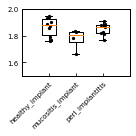

In [668]:
group_sort = ['healthy_implant', 'mucositis_implant', 'peri_implantitis']

xticks = np.arange(len(group_sort)) + 1
dict_group_xtick = dict(zip(group_sort, xticks))

s=5

fig, ax = ip.general_plot(dims=(2,2), ft=7)

for group in group_sort:
    x = dict_group_xtick[group]
    bcvals = dict_group_bcvals[group]
    xs = [x] * len(bcvals) + np.random.rand(len(bcvals)) * 0.2 - 0.1

    # color = dict_sciname_color[scn]
    box = ax.boxplot([bcvals], positions=[x], vert=True, widths=0.5)

    ax.scatter(xs, bcvals, color='k', s=s)

_ = ax.set_xticks(
    xticks, group_sort, rotation=45, ha="right", va="top", rotation_mode="anchor"
)
ax.set_xlim(0,np.max(xticks) + 1)
ax.set_ylim(0,2)
# ax.set_ylabel('Homogeneity\n(Fuzzy box counting fractal dimension)')
ax.set_ylim(1.5,2)
out_fn = sample_compare_dir + "/box_counting/fuzzy_box_counting_bygroup.png".format(
    group
)
ip.check_dir(out_fn)
ip.save_fig(out_fn)

multispecies box counting

In [652]:
fuzzy_box_count_all_fn = sample_compare_dir + '/multispecies_box_counting_table.csv'
fuzzy_box_count_all = pd.read_csv(fuzzy_box_count_all_fn, index_col=0)
fuzzy_box_count_all

,slope,intercept,r_value,r_squared,p_value,std_err
2023_10_18_hsdm_slide_IIL_fov_01,-1.650706,10.869192,-0.999767,0.999533,8.162749e-08,0.017831
2023_10_18_hsdm_slide_IIIB_fov_01,-1.886912,11.221470,-0.999224,0.998449,9.027934e-07,0.037187
2023_10_18_hsdm_slide_IIIL_fov_01,-1.441676,9.705942,-0.999515,0.999029,3.533793e-07,0.022468
2023_02_18_hsdm_group_batch2_patient_11_fov_01,-1.822027,11.951265,-0.998467,0.996936,3.525005e-06,0.050508
2023_02_18_hsdm_group_batch1_patient_1_fov_01,-1.111827,8.937433,-0.996236,0.992485,2.122981e-05,0.048373
2023_02_18_hsdm_group_batch1_patient_1_fov_02,-1.151208,6.685018,-0.997063,0.994134,1.292848e-05,0.044215
2023_02_18_hsdm_group_batch1_patient_2_fov_01,-1.940213,12.403737,-0.999814,0.999629,5.168888e-08,0.018695
2023_02_18_hsdm_group_batch1_patient_3_fov_01,-1.948736,12.363813,-0.999866,0.999731,2.707515e-08,0.015974
2023_02_18_hsdm_group_batch1_patient_4_fov_01,-1.748889,9.528584,-0.998549,0.997100,3.157055e-06,0.047160
2023_02_18_hsdm_group_batch1_patient_7_fov_01,-2.000000,10.498410,-1.000000,1.000000,1.500000e-40,0.000000


In [653]:
exclude_sns = [
    '2023_10_16_hsdm_slide_IB_fov_01', 
    '2023_10_16_hsdm_slide_IB_fov_03', 
    '2023_10_16_hsdm_slide_IB_fov_02', 
    '2022_12_16_harvardwelch_patient_18_tooth_2_aspect_MB_depth__fov_01',
    '2022_12_16_harvardwelch_patient_19_tooth_15_aspect_MF_depth_sub_fov_01',
    '2022_12_16_harvardwelch_patient_19_tooth_30_aspect_MB_depth_sub_fov_01',
    '2023_02_18_hsdm_group_II_patient_7_fov_02',

]

In [654]:
dict_group_bcvals = defaultdict(list)
for group, sns in dict_group_sn.items():
    print(group)
    for sn in sns:
        if not sn in exclude_sns:
            bcval = -fuzzy_box_count_all.loc[sn,'slope']
            dict_group_bcvals[group].append(bcval)


healthy_tooth
periodontitis_tooth
healthy_implant
peri_implantitis
mucositis_implant


(1.0, 2.0)

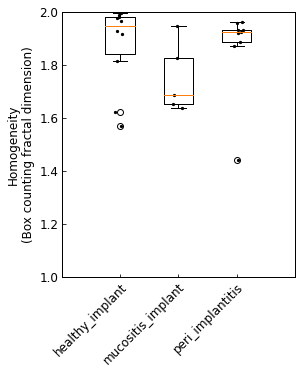

In [655]:
group_sort = ['healthy_implant', 'mucositis_implant', 'peri_implantitis']

xticks = np.arange(len(group_sort)) + 1
dict_group_xtick = dict(zip(group_sort, xticks))

s=5

fig, ax = ip.general_plot(dims=(4,5), ft=12)

for group in group_sort:
    x = dict_group_xtick[group]
    bcvals = dict_group_bcvals[group]
    xs = [x] * len(bcvals) + np.random.rand(len(bcvals)) * 0.2 - 0.1

    # color = dict_sciname_color[scn]
    box = ax.boxplot([bcvals], positions=[x], vert=True, widths=0.5)

    ax.scatter(xs, bcvals, color='k', s=s)

_ = ax.set_xticks(
    xticks, group_sort, rotation=45, ha="right", va="top", rotation_mode="anchor"
)
ax.set_xlim(0,np.max(xticks) + 1)
ax.set_ylim(0,2)
ax.set_ylabel('Homogeneity\n(Box counting fractal dimension)')
ax.set_ylim(1,2)
# out_fn = cluster_size_dir + "/size_distribution_boxplot_bygroup.png".format(
#     group
# )
# ip.check_dir(out_fn)
# ip.save_fig(out_fn)

## Just look at largest clusters

Get largest clusters for each sciname

In [502]:
# topn = 1
# dict_sn_large_clusters = defaultdict(dict)
# for sn, dict_scn_clsize in dict_sn_scn_clsize.items():
#     for scn, clsizes in dict_scn_clsize.items():      
#         cls_topn = np.sort(clsizes)[-topn:]
#         cls_mean = np.mean(cls_topn)
#         dict_sn_large_clusters[sn][scn] = cls_mean
        

Get largest clusters for each sample

In [504]:
# topn = 1
# dict_sn_topn = {}
# for sn, dict_scn_clsize in dict_sn_large_clusters.items():
#     group = dict_sn_group[sn]
#     sizes = []
#     for scn, size in dict_scn_clsize.items():
#         sizes.append(size)
#     sz_sort = np.sort(sizes)
#     sz_topn = sz_sort[-topn:]
#     sz_mean = np.mean(sz_topn)
#     dict_sn_topn[sn] = sz_mean
    


        

In [513]:
dict_sn_top = {}
for sn, dict_scn_clsize in dict_sn_scn_clsize.items():
    sn_top = 0
    for scn, clsizes in dict_scn_clsize.items():      
        scn_top = np.sort(clsizes)[-1]
        sn_top = scn_top if scn_top > sn_top else sn_top
    dict_sn_top[sn] = sn_top

        

In [519]:
positions

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [2, 2, 2, 2, 2, 2],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]]

Text(0, 0.5, 'Largest cluster in tilescan')

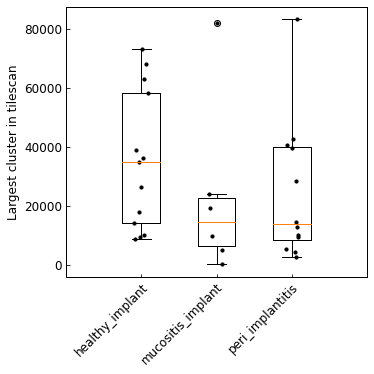

In [521]:
s = 10

fig, ax = ip.general_plot(dims=(5,5), ft=12)

group_list = ['healthy_implant', 'mucositis_implant', 'peri_implantitis']
xticks = np.arange(len(group_list)) + 1
dict_group_xtick = dict(zip(group_list, xticks))
# col_list = 
# dict_group_color = dict(group_list, col_list)

dict_group_sizes = defaultdict(list)
for sn, size in dict_sn_top.items():
    group = dict_sn_group[sn]
    if 'implant' in group:
        x = dict_group_xtick[group] + np.random.rand() * 0.2 - 0.1
        dict_group_sizes[group].append(size)
        ax.scatter(x, size, color='k', s=s)

sizes = [dict_group_sizes[g] for g in group_list]
# positions = [[xt]*len(s) for xt, s in zip(xticks, sizes)]

box = ax.boxplot(sizes, positions=xticks, vert=True, widths=0.5)

_ = ax.set_xticks(
    xticks, group_list, rotation=45, ha="right", va="top", rotation_mode="anchor"
)
ax.set_xlim(0,np.max(xticks) + 1)
ax.set_ylabel('Largest cluster in tilescan')


In [573]:
a = pd.DataFrame([])
a.append(pd.DataFrame({'a':[1,2,3], 'b':[4,5,6]}))

,a,b
0,1,4
1,2,5
2,3,6
